In [1]:
# the purpose of this test is to check if the 2D kernel can learn to generate pattern present in the training data
# step 1. test of data with same attributes with the same length
# step 2  test of data with same attributes with the different length
# step 3. test with different attributes  and different length

# data generation
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
import math
from torch_geometric.data import Data
import numpy as np



def color_for_element(atomic_num):
    color ='lightgrey'
    if(atomic_num == 1):# H
        color = 'lightgrey'
    elif(atomic_num ==6): # C
        color = 'black'
    elif(atomic_num ==8): # O
        color = 'red'
    elif(atomic_num ==7): # N
        color = 'blue'
    elif(atomic_num ==16): # S
        color = 'yellow'
    elif(atomic_num == 15): # P
        color = 'orange'
    elif(atomic_num ==9): # F
        color = 'lime'
    elif(atomic_num ==17): # Cl
        color = 'limegreen'
    elif(atomic_num ==35): # Br
        color = 'forestgreen'
    elif(atomic_num ==53): # I
        color = 'darkgreen'
    return color

def linestyle_for_bond_type(edge_attr):
    linestyle='-'
    if(edge_attr == 2):
        linestyle='--'
    elif(edge_attr==3):
        linestyle=':'
    elif(edge_attr==4):
        linestyle='-.'
    return linestyle

def angle_between_two_vectors(vector_1, vector_2):

#     print('\n')
#     print('vector1:')
#     print(vector_1)
#     print('vector2:')
#     print(vector_2)
    if torch.all(torch.eq(vector_1,vector_2)):
        return None
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
#     print('norm vector1:')
#     print(unit_vector_1)
    
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
#     print('norm vector2:')
#     print(unit_vector_2)
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)
#     print(f'dot:{dot_product}')
    angle = np.arccos(dot_product)
    angle = angle/math.pi *180
    return angle

def edge_length(vector):
    return np.linalg.norm(vector)
    

def vis(data = None, x_neighbor = None, x_focal = None, p_neighbor=None, p_focal=None, edge_attr_neighbor = None, vis_kernel=False, marker_size=None, vis_element=False, only_graph=False):
    fig_size = 5
    marker_size = 500
    lower_bound = -1.5
    upper_bound = 2
    
#     if(vis_kernel ==False):
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)


    if data is not None:
        try:
            p_neighbor = data.p_neighbor
            p_focal = data.p_focal

        except:
            raise Exception('In data, either center position p_focal or position p is not provided')
                  
        try:
            x_neighbor = data.x_neighbor
        except:
            x_neighbor = None
        try:
            x_focal = data.x_focal
        except:
            x_focal = None
        try:
            edge_attr_neighbor = data.edge_attr_neighbor
        except:
            edge_attr_neighbor = None
    else:
        if p_neighbor is None or p_focal is None:
            raise Exception('either provide data, or provide both p_neighbor and p_focal is provided')
    
    if(vis_kernel==False):
        print('====data info====')

        print('p_neighbor:')
        print(p_neighbor)

        if x_neighbor is not None:
            print('\n')
            print('x_neighbor:')
            print(x_neighbor)

        if x_focal is not None:
            print('\n')
            print('x_focal:')
            print(x_focal)

        if p_focal is not None:
            print('\n')
            print('p_focal:')
            print(p_focal)

        if edge_attr_neighbor is not None:
            print('\n')
            print('edge_attr_neighbor:')
            print(edge_attr_neighbor)
    
    if (vis_graph==True):
    
        print('\n')
        s = p_neighbor.shape[0]
        calibrated_p_neighbor = p_neighbor-p_focal
        for i in range(s):
            for j in range(i):
                angle = angle_between_two_vectors(calibrated_p_neighbor[i], calibrated_p_neighbor[j])
                if (angle is not None):
                    print(f'{i}-{j} angle:{angle}')
        print('\n')


        for i in range(s):
            print(f'{i} length:{edge_length(calibrated_p_neighbor[i])}')

        print('=========')

    # annotate and color
    for i in range(p_neighbor.shape[0]):
        if x_neighbor is None or ( vis_kernel == True and vis_element == False):
            plt.annotate(i, (p_neighbor[i,:]))
            color = 'blue'
        else:
            pt = Chem.GetPeriodicTable() 
            atomic_num = int(x_neighbor[i,0].item())
            plt.annotate(pt.GetElementSymbol(atomic_num),(p_neighbor[i,:]))
            if marker_size is None:
                marker_size = x_neighbor[i,2].item()*500
            color = color_for_element(atomic_num)
            
        # draw neighors
        plt.scatter(p_neighbor[i,0], p_neighbor[i,1], color = color, s = marker_size, alpha = 0.5)
        
    # draw focal    
    if ((vis_kernel == True) and (vis_element == False)):
        color = 'dimgrey'
    else:
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x_focal[0][0].item())
        plt.annotate(pt.GetElementSymbol(atomic_num),(0,0))
        color = color_for_element(atomic_num)
    plt.scatter(p_focal[0], p_focal[1], color = color, s= marker_size, alpha = 0.5)
    
    # draw bonds
    for i, each_p_neighbor in enumerate(p_neighbor):
        each_edge_attr_neighbor = edge_attr_neighbor[i]
        linestyle = linestyle_for_bond_type(each_edge_attr_neighbor)
        plt.plot([each_p_neighbor[0], p_focal[0]],[each_p_neighbor[1],p_focal[1]], color = 'black', linestyle=linestyle)
    plt.show()    

def get_kernel_from_kernelsetconv(model):
    params = model.state_dict()
#     for param in params:
#         print(param)
    
#     num_kernel_sets = int(len(params)/4)
#     print(f'num_kernel_sets:{num_kernel_sets}')

    kernel_list = []
    for i in range(4):
        prefix = 'fixed'# these will be overwrite by the trainables and will NOT show
        x_center_array = params[f'{prefix}_kernelconv_set.{i}.x_center']
        x_support_array = params[f'{prefix}_kernelconv_set.{i}.x_support']
        edge_attr_support_array = params[f'{prefix}_kernelconv_set.{i}.edge_attr_support']
        p_support_array = params[f'{prefix}_kernelconv_set.{i}.p_support']
        
        prefix = 'trainable'
        x_center_array = params[f'{prefix}_kernelconv_set.{i}.x_center']
        print(f'array_type:{type(x_center_array)}')
        x_support_array = params[f'{prefix}_kernelconv_set.{i}.x_support']
        edge_attr_support_array = params[f'{prefix}_kernelconv_set.{i}.edge_attr_support']
        p_support_array = params[f'{prefix}_kernelconv_set.{i}.p_support']
        output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
        kernel_list.append(output_kernel)
    return kernel_list


# def get_kernel_from_kernellayer(model):
#     params = model.state_dict()
# #     for param in params:
# #         print(param)
    
#     num_kernel_sets = int(len(params)/4)
# #     print(f'num_kernel_sets:{num_kernel_sets}')
    
#     kernel_list = []
#     for i in range(num_kernel_sets):

#         x_center_array = params[f'conv.kernel_set.{i}.x_center']
#         x_support_array = params[f'conv.kernel_set.{i}.x_support']
#         edge_attr_support_array = params[f'conv.kernel_set.{i}.edge_attr_support']
#         p_support_array = params[f'conv.kernel_set.{i}.p_support']
#         output_kernel = Data(p_support = torch.tensor(p_support_array), x_support = torch.tensor(x_support_array), x_center = torch.tensor(x_center_array), edge_attr_support = torch.tensor(edge_attr_support_array))
#         kernel_list.append(output_kernel)
#     return kernel_list



def vis_kernel(kernel, vis_element= False, only_graph=False):
    kernel_list=[]
    if isinstance(kernel, Data):
        kernel_list = [kernel]
    else:
        kernel_list = kernel
    
    for kernel in kernel_list:
        num_sets = kernel.x_support.shape[0]

        for l in range(num_sets):
            kernel.x_neighbor = kernel.x_support[l, :,:]

            kernel.p_neighbor = kernel.p_support[l,:,:]

            kernel.x_focal = kernel.x_center[l,:,:]

            p_center = torch.tensor([0,0])    
            kernel.p_focal = p_center

            kernel.edge_attr_neighbor = kernel.edge_attr_support[l, :,:]

#             subplot(num_sets,4,l+1)
            vis(kernel, vis_kernel=True, vis_element=vis_element)
            if(only_graph==False):
                print(f'===={l}th kernel info====')


                print(f'{l}th-p_support:')
                print(kernel.p_neighbor.shape)

                if x is not None:
                    print('\n')
                    print(f'{l}th-x_support:')
                    print(kernel.x_neighbor)

                if x_focal is not None:
                    print('\n')
                    print(f'{l}th-x_center:')
                    print(kernel.x_focal)

                if p_focal is not None:
                    print('\n')
                    print(f'{l}th-p_center:')
                    print(kernel.p_focal.shape)

                if edge_attr is not None:
                    print('\n')
                    print(f'{l}th-edge_attr_support:')
                    print(kernel.edge_attr_neighbor)
            
        
def vis_graph(data, lower_bound = -4, upper_bound = 5, fig_size=5,  marker_size = 500):

    
    plt.figure(figsize = (fig_size,fig_size))
    plt.xlim(lower_bound,upper_bound)
    plt.ylim(lower_bound,upper_bound)
    
    
    x = data.x
    p = data.p
    edge_index = data.edge_index
    edge_attr = data.edge_attr
    
    for i in range(x.shape[0]):
        pt = Chem.GetPeriodicTable() 
        atomic_num = int(x[i,0].item())
        color = color_for_element(atomic_num)
        plt.annotate(i,(p[i,0], p[i,1]))
        plt.scatter(p[i,0], p[i,1], color = color, s = marker_size, alpha = 0.5)
    

    for col in range(edge_index.shape[1]):
        start_idx = edge_index[0,col]
        end_idx = edge_index[1,col]
#         print(f'start_idx:{start_idx}, end_idx:{end_idx}')
        linestyle = linestyle_for_bond_type(edge_attr[col])       
        plt.plot([p[start_idx][0], p[end_idx][0]],  [p[start_idx][1],p[end_idx][1]], color = 'black', linestyle = linestyle, alpha =0.5)
    
#     legend = plt.legend(handles=['--'], labels=["red dotted line"], handlelength=5)

    
def vis_kernel_in_kernelsetconv(model):
    kernel = get_kernel_from_kernelsetconv(model)
    if isinstance(kernel, Data):
        print(f'kernel:{kernel}')
        
    else:
        pass
        print('kernels:')
        for k in kernel:
            print(k)
    vis_kernel(kernel)

# def vis_kernellayer_in_kernellayer(model):
#     kernel = get_kernel_from_kernellayer(model)
#     if isinstance(kernel, Data):
#         print(f'kernel:{kernel}')
        
#     else:
#         pass
#         print('kernels:')
#         for k in kernel:
#             print(k)
#     vis_kernel(kernel)
    
    
def rotate(p_center, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given p_center.

    The angle should be given in degrees.
    """
    angle = angle * math.pi/180
    
    ox, oy = p_center
#     print(f'ox:{ox}, oy:{oy}')
    px, py = point
#     print(f'px:{px}, py:{py}')
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])

def tensor_rotate(p_center, points, angle):
    l = []
    for point in points:
        new_p = rotate(p_center, point, angle)
        l.append(new_p)
    l = torch.stack(l, dim=0)
#     print(f'f:{l.shape}')
    return torch.tensor(l)

def graph_rotate(data, p_center, angle):
    p = data.p
    new_p = tensor_rotate(p_center, p, angle)
    new_data = data.clone()
    new_data.p = new_p
    return new_data

# new_p = tensor_rotate(p_center, p, 180)
# # print(new_p)
# # vis(new_p, p_center)

# data_list = []
# for i in range(0, 370, 10):
#     new_p = tensor_rotate(p_center, p, i)
#     data = Data(p = new_p, p_center = p_center)
#     data_list.append(data)

# # for data in data_list:
# #     vis(data, p_center)


# translate
trans = torch.tensor([[1,1]])

# S = 3
x_support = torch.tensor([[1],[1],[1]], dtype = torch.float)
p_support = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1]], dtype = torch.float)
p_support+=trans
p_center = torch.tensor([0,0]) + trans.squeeze(dim =0)


#S = 4
# data
# x = torch.tensor([[1],[1],[1],[1]], dtype = torch.float)
# p = torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [math.sqrt(0.5), math.sqrt(0.5)]], dtype = torch.float)


# vis(p_neighbor = p_support, p_focal = p_center)
# model = KernelSetConv(L = 10, D=2, node_attr_dim = 5, edge_attr_dim =1)
# vis_kernel_in_model(model)

In [2]:
P =torch.tensor([[0,1, 0],[1,0,0],[0,0,1]], dtype=torch.float)
S = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float)
ones = torch.ones(P.shape)
a=S.mm(P)
print(a)

tensor([[2., 1., 3.],
        [5., 4., 6.],
        [8., 7., 9.]])


calculating rdkit element representation lookup table
====data info====
p_neighbor:
tensor([[ 1.2990e+00,  7.5000e-01],
        [-1.2990e+00,  7.5000e-01],
        [-1.9429e-16, -1.5000e+00]])


x_neighbor:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


x_focal:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


p_focal:
tensor([-8.3267e-17, -1.1102e-16])


edge_attr_neighbor:
tensor([[2],
        [1],
        [1]])


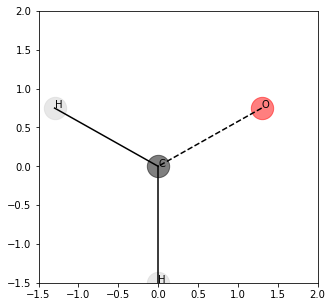

/home/liuy69/bin/anaconda2/envs/GCN_property/lib/python3.6/site-packages/ipykernel_launcher.py:370: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [3]:
# test of p with different attributes
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit
import torch
from torch_geometric.data import Data

elements = ['H', 'C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
elem_lst =None


def lookup_from_rdkit(elements):
    global elem_lst

    if elem_lst is None:
        print('calculating rdkit element representation lookup table')
        elem_rep_lookup = []
        for elem in elements:
            pt = Chem.GetPeriodicTable() 

            if isinstance(elem, int):
                num=elem
                sym=pt.GetElementSymbol(num)
            else:
                num = pt.GetAtomicNumber(elem)
                sym = elem
            w = pt.GetAtomicWeight(elem)

            Rvdw = pt.GetRvdw(elem)
        #     Rcoval = pt.GetRCovalent(elem)
            valence = pt.GetDefaultValence(elem)
            outer_elec = pt.GetNOuterElecs(elem)

            elem_rep=[num, w,  Rvdw, valence, outer_elec]
#             print(elem_rep)


            elem_rep_lookup.append(elem_rep)
        elem_lst = elem_rep_lookup.copy()
        return elem_rep_lookup
    else:
        return elem_lst




def get_atom_rep(atomic_num, package='rdkit'):
    '''use rdkit or pymatgen to generate atom representation
    '''
    max_elem_num = 118
    element_nums= [x+1 for x in range(max_elem_num)]


    if package =='rdkit':
        elem_lst = lookup_from_rdkit(element_nums)
    elif package == 'pymatgen':
        raise Exception('pymatgen implementation is deprecated.')
        #elem_lst = lookup_from_pymatgen(element_nums)
    else:
        raise Exception('cannot generate atom representation lookup table')

    result = 0
    try:
        result = elem_lst[atomic_num - 1]
    except:
        print(f'error: atomic_num {atomic_num} does not exist')

    return result


def smiles2graph(D, smiles):
    if D==None:
        raise Exception('smiles2grpah() needs to input D to specifiy 2D or 3D graph generation.')
    
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
#     mol.UpdatePropertyCache(strict=False)
    mol = Chem.AddHs(mol)
    
    if D==2:
        rdkit.Chem.rdDepictor.Compute2DCoords(mol)
    if D==3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
    
    conf = mol.GetConformer()
    
    atom_pos = []
    atom_attr =[]
    
    # get atom attributes and positions
    for i, atom in enumerate(mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()
        h = get_atom_rep(atomic_num)
    
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
    
    # get bond attributes
    edge_list = []
    edge_attr_list =[]
    for idx, edge in enumerate(mol.GetBonds()):
        i = edge.GetBeginAtomIdx()
        j = edge.GetEndAtomIdx()
        
        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type ==Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type ==Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type ==Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type ==Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]     
            

        edge_list.append((i, j))
        edge_attr_list.append(bond_attr) 
#         print(f'i:{i} j:{j} bond_attr:{bond_attr}')

        edge_list.append((j, i))
        edge_attr_list.append(bond_attr)    
#         print(f'j:{j} j:{i} bond_attr:{bond_attr}')    
    
    x = torch.tensor(atom_attr)
    p = torch.tensor(atom_pos)
    edge_index = torch.tensor(edge_list).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list)
#     print(p)
        
    return x, p, edge_index, edge_attr

smiles = 'C(=O)([H])[H]'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# for 3D
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# conf = mol.GetConformer()


# for 2D
rdkit.Chem.rdDepictor.Compute2DCoords(mol)
conf = mol.GetConformer()
atom_pos = []
atom_attr =[]
x_focal = None
for i, atom in enumerate(mol.GetAtoms()):
    atomic_num = atom.GetAtomicNum()
    h = get_atom_rep(atomic_num, 'rdkit')
    if atomic_num == 6:
        p_focal = torch.tensor([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z ])
        x_focal = torch.tensor(h)
    else:
        atom_pos.append([conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y])#, conf.GetAtomPosition(i).z])
        atom_attr.append(h)
        
edge_attr = []
for j, edge in enumerate(mol.GetBonds()):
    bond_type = edge.GetBondType()
    if bond_type ==Chem.rdchem.BondType.SINGLE:
        edge_attr.append(1)
    elif bond_type ==Chem.rdchem.BondType.DOUBLE:
        edge_attr.append(2)
    elif bond_type ==Chem.rdchem.BondType.TRIPLE:
        edge_attr.append(3)
    elif bond_type ==Chem.rdchem.BondType.AROMATIC:
        edge_attr.append(4)
edge_attr_neighbor = torch.tensor(edge_attr).unsqueeze(0).T
                              
p_neighbor = torch.tensor(atom_pos)
x_neighbor = torch.tensor(atom_attr)                              
x_focal = x_focal.unsqueeze(0)
# print(p)
# print(origin)
# print(x)
  
    
#============generate a list of same receptive field 
data = Data(p_neighbor=p_neighbor, x_neighbor=x_neighbor, x_focal=x_focal, edge_attr_neighbor=edge_attr_neighbor, p_focal=p_focal)
# print(data)
vis(data=data)

data_list = []
for i in range(0, 370, 10):
    new_p = tensor_rotate(p_focal, p_neighbor, i)
    data = Data(p = new_p, p_focal = p_focal, x_neighbor=x_neighbor, x_focal = x_focal, edge_attr = edge_attr)
    data_list.append(data)
#     vis(data=data)







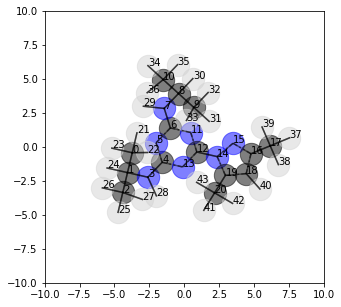

In [4]:
x =torch.tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 7.0000, 14.0070,  1.6000,  3.0000,  5.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],                                                                                                                                                                     [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])  
p = torch.tensor([[-3.7256, -0.4303],                                                                                                                                                                                                [-4.0641, -1.8916],                                                                                                                                                                                                [-4.4027, -3.3529],                                                                                                                                                                                                [-2.6028, -2.2302],                                                                                                                                                                                                [-1.5790, -1.1339],                                                                                                                                                                                                [-2.0164,  0.3008],                                                                                                                                                                                                [-0.9926,  1.3971],                                                                                                                                                                                                [-1.4300,  2.8319],                                                                                                                                                                                                [-0.4062,  3.9281],                                                                                                                                                                                                [ 0.6900,  2.9043],                                                                                                                                                                                                [-1.5024,  4.9520],                                                                                                                                                                                                [ 0.4687,  1.0585],                                                                                                                                                                                                [ 0.9062, -0.3763],                                                                                                                                                                                                [-0.1177, -1.4725],                                                                                                                                                                                                [ 2.3675, -0.7148],                                                                                                                                                                                                [ 3.5003,  0.2684],                                                                                                                                                                                                [ 4.7854, -0.5051],                                                                                                                                                                                                [ 6.1666,  0.0799],                                                                                                                                                                                                [ 4.4469, -1.9664],                                                                                                                                                                                                [ 2.9525, -2.0960],                                                                                                                                                                                                [ 2.1789, -3.3812],                                                                                                                                                                                                [-3.3870,  1.0310],                                                                                                                                                                                                [-2.6322, -0.4120],                                                                                                                                                                                                [-5.1869, -0.0918],                                                                                                                                                                                                [-5.5254, -1.5531],                                                                                                                                                                                                [-4.7412, -4.8142],                                                                                                                                                                                                [-5.8640, -3.0144],                                                                                                                                                                                                [-2.9935, -3.8671],                                                                                                                                                                                                [-1.9937, -3.6010],                                                                                                                                                                                                [-2.9217,  2.9898],                                                                                                                                                                                                [ 0.6176,  5.0244],                                                                                                                                                                                                [ 1.7863,  1.8804],                                                                                                                                                                                                [ 1.7139,  4.0005],                                                                                                                                                                                                [ 0.1592,  1.9483],                                                                                                                                                                                                [-2.5987,  5.9758],                                                                                                                                                                                                [-0.4786,  6.0482],                                                                                                                                                                                                [-2.6523,  3.9887],                                                                                                                                                                                                [ 7.5479,  0.6649],                                                                                                                                                                                                [ 6.7517, -1.3013],                                                                                                                                                                                                [ 5.5816,  1.4611],                                                                                                                                                                                                [ 5.4301, -3.0993],                                                                                                                                                                                                [ 1.4054, -4.6663],                                                                                                                                                                                                [ 3.4641, -4.1547],                                                                                                                                                                                                [ 0.8938, -2.6076]])       
edge_index = torch.tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,                                                                                                                                             8, 10,  6, 11, 11, 12, 12, 13, 12, 14, 14, 15, 15, 16, 16, 17, 16, 18,                                                                                                                                            18, 19, 19, 20, 13,  4, 19, 14,  0, 21,  0, 22,  0, 23,  1, 24,  2, 25,                                                                                                                                             2, 26,  2, 27,  3, 28,  7, 29,  8, 30,  9, 31,  9, 32,  9, 33, 10, 34,                                                                                                                                            10, 35, 10, 36, 17, 37, 17, 38, 17, 39, 18, 40, 20, 41, 20, 42, 20, 43],                                                                                                                                          [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,                                                                                                                                            10,  8, 11,  6, 12, 11, 13, 12, 14, 12, 15, 14, 16, 15, 17, 16, 18, 16,                                                                                                                                            19, 18, 20, 19,  4, 13, 14, 19, 21,  0, 22,  0, 23,  0, 24,  1, 25,  2,                                                                                                                                            26,  2, 27,  2, 28,  3, 29,  7, 30,  8, 31,  9, 32,  9, 33,  9, 34, 10,                                                                                                                                            35, 10, 36, 10, 37, 17, 38, 17, 39, 17, 40, 18, 41, 20, 42, 20, 43, 20]])  
edge_attr = torch.tensor([[1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [4],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1],                                                                                                                                                                                                               [1]])    
data = Data(x = x, p= p , edge_index= edge_index, edge_attr = edge_attr)
vis_graph(data, lower_bound = -10, upper_bound = 10)



In [5]:
# customized_kernel.py
import torch

from torch_geometric.data import Data

from rdkit import Chem
import rdkit
# from rdkit import Chem
# # from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

import pandas as pd
import os

get_atom_rep


def generate_1hop_kernel(D, typical_compound_smiles, center_atom_id):
    #     '''
    #     given a typical compound containing a certain kernal, and the center atom id, genrate the kernel
    #     '''
    if D == None:
        raise Exception('generate_kernel2grpah() needs to input D to specifiy 2D or 3D graph generation.')

    smiles = typical_compound_smiles.replace(r'/=', '=')
    smiles = typical_compound_smiles.replace(r'\=', '=')

    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    # mol.UpdatePropertyCache(strict=False)
    mol = Chem.AddHs(mol)

    if D == 2:
        Chem.rdDepictor.Compute2DCoords(mol)
    if D == 3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)

    conf = mol.GetConformer()

    all_atoms = mol.GetAtoms()
    center_atom = all_atoms[center_atom_id]
    # print(f'center atom:{center_atom.GetSymbol()}')

    atom_pos = []
    atom_attr = []

    supports = center_atom.GetNeighbors()

    x_center = get_atom_rep(center_atom.GetAtomicNum())

    p_list = []
    x_list = []
    bond_attr_list = []
    # print()
    # print('atom idx:')
    # for i, atom in enumerate(all_atoms):
    #     print(f'{atom.GetIdx()}, {atom.GetSymbol()}')

    for idx, edge in enumerate(center_atom.GetBonds()):
        support_start_id = edge.GetBeginAtomIdx()
        support_end_id = edge.GetEndAtomIdx()
#         print(f'support_start_id:{support_start_id}')
#         print(f'support_end_id:{support_end_id}')
        if (support_start_id == center_atom_id):
            support_id = support_end_id
        else:
            support_id = support_start_id
        support = all_atoms[support_id]
        x_list.append(get_atom_rep(support.GetAtomicNum()))
        if D == 2:
            p_support = p_list.append([conf.GetAtomPosition(support_id).x - conf.GetAtomPosition(center_atom_id).x, conf.GetAtomPosition(support_id).y - conf.GetAtomPosition(center_atom_id).y])
        if D == 3:
            p_support = p_list.append([conf.GetAtomPosition(support_id).x - conf.GetAtomPosition(center_atom_id).x, conf.GetAtomPosition(support_id).y -
                                       conf.GetAtomPosition(center_atom_id).y, conf.GetAtomPosition(support_id).z - conf.GetAtomPosition(center_atom_id).z])

        bond_attr = None
        bond_type = edge.GetBondType()
        if bond_type == Chem.rdchem.BondType.SINGLE:
            bond_attr = [1]
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            bond_attr = [2]
        elif bond_type == Chem.rdchem.BondType.TRIPLE:
            bond_attr = [3]
        elif bond_type == Chem.rdchem.BondType.AROMATIC:
            bond_attr = [4]
        bond_attr_list.append(bond_attr)

    x_center = torch.tensor(x_center).unsqueeze(0).unsqueeze(0)
    x_support = torch.tensor(x_list).unsqueeze(0)
    p_support = torch.tensor(p_list).unsqueeze(0)
    edge_attr_support = torch.tensor(bond_attr_list, dtype=p_support.dtype).unsqueeze(0)

#     print('x_center')
#     print(x_center)
#     print('x_support')
#     print(x_support)
#     print('p_support')
#     print(p_support)
#     print('edge_attr_support')
#     print(edge_attr_support)
    data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
    return data  # x_center, x_support, p_support, edge_attr_support



def generate_2hop_kernel(D, typical_compound_smiles, center_atom_id, hops = 2):
    #     '''
    #     given a typical compound containing a certain kernal, and the center atom id, genrate the kernel
    #     '''
    if D == None:
        raise Exception('generate_kernel2grpah() needs to input D to specifiy 2D or 3D graph generation.')

    smiles = typical_compound_smiles.replace(r'/=', '=')
    smiles = typical_compound_smiles.replace(r'\=', '=')

    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    # mol.UpdatePropertyCache(strict=False)
    mol = Chem.AddHs(mol)

    if D == 2:
        Chem.rdDepictor.Compute2DCoords(mol)
    if D == 3:
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)

    conf = mol.GetConformer()

    all_atoms = mol.GetAtoms()
    center_atom = all_atoms[center_atom_id]
    # print(f'center atom:{center_atom.GetSymbol()}')

    atom_pos = []
    atom_attr = []

    supports = center_atom.GetNeighbors()

    x_center = get_atom_rep(center_atom.GetAtomicNum())
    
    if hops == 1:
        return generate_1hop_kernel(D, typical_compound_smiles, center_atom_id)
 
    for hop in range(1, hops+1):
        for center_atom in supports:
            kernel = generate_2hop_kernel(D, typical_compound_smiles, center_atom_id, hops = hops-1)
            

def read_kernel_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    df = df.transpose()
    kernel_dict = df.to_dict(orient='list')
    return kernel_dict


def print_kernel_files():
    root = '../customized_kernels'
    files = os.listdir(root)
    for file in files:
        df = pd.read_csv(root + '/' + file)
        print(df)


# degree1
hop1_degree1_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel1.csv')

# degree2
hop1_degree2_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel2.csv')


# degree3
hop1_degree3_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel3.csv')


# degree4
hop1_degree4_functional_groups = read_kernel_from_csv('../customized_kernels/customized_kernel4.csv')


# ===1hop kernels - 2D===
# degree1
functional_groups = hop1_degree1_functional_groups
hop1_2D_degree1_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree2
functional_groups = hop1_degree2_functional_groups
hop1_2D_degree2_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree3
functional_groups = hop1_degree3_functional_groups
hop1_2D_degree3_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree4
functional_groups = hop1_degree4_functional_groups
hop1_2D_degree4_kernels_list = [
    generate_1hop_kernel(2, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]

# ===1hop kernels - 3D===
# degree1
functional_groups = hop1_degree1_functional_groups
hop1_3D_degree1_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree2
functional_groups = hop1_degree2_functional_groups
hop1_3D_degree2_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree3
functional_groups = hop1_degree3_functional_groups
hop1_3D_degree3_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]
# degree4
functional_groups = hop1_degree4_functional_groups
hop1_3D_degree4_kernels_list = [
    generate_1hop_kernel(3, functional_groups[name][0], functional_groups[name][1]) for name in functional_groups.keys()]


def get_hop1_kernel_list(D):
    if D == 2:
        # to make sure the original list is untouched, use the copied one
        return hop1_2D_degree1_kernels_list.copy(), hop1_2D_degree2_kernels_list.copy(), hop1_2D_degree3_kernels_list.copy(), hop1_2D_degree4_kernels_list.copy()
    elif D == 3:
        return hop1_3D_degree1_kernels_list.copy(), hop1_3D_degree2_kernels_list.copy(), hop1_3D_degree3_kernels_list.copy(), hop1_3D_degree4_kernels_list.copy()
    else:
        raise Exception('get_hop1_kernel_list(): invalid D')
        
def get_hop2_kernel_list(D):
    if D == 2:
        pass

In [10]:
# kernels.py

from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import torch
from torch.nn import ModuleList, CosineSimilarity, Module, ModuleList, Linear, Sigmoid
# from torch.nn import
from torch.nn.parameter import Parameter

from itertools import permutations
import math
import pandas as pd

import os



torch.autograd.set_detect_anomaly(True) 

class KernelConv(Module):
    def __init__(self, L=None, D=None, num_supports=None, node_attr_dim=None, edge_attr_dim=None, init_kernel=None, requires_grad=True, init_length_sc_weight = 0.1, init_angle_sc_weight = 0.5,  init_center_attr_sc_weight = 0.8, init_support_attr_sc_weight = 0.8, init_edge_attr_support_sc_weight=0.8, weight_requires_grad= False):
        super(KernelConv, self).__init__()
        if init_kernel is None:
            if (L is None) or (D is None) or (num_supports is None) or (node_attr_dim is None) or (edge_attr_dim is None):
                raise Exception(
                    'either numer of kernels L, convolution dimention D, number of support num_supports or feature dimension node_attr_dim is not specified')
            else:
                init_kernel = Data(x_center=torch.randn(L, 1, node_attr_dim), x_support=torch.randn(
                    L, num_supports, node_attr_dim), edge_attr_support=torch.randn(L, num_supports, edge_attr_dim), p_support=torch.randn(L, num_supports, D))

        self.num_kernels = init_kernel.x_center.shape[0]

        x_center_tensor = init_kernel.x_center
        self.x_center = Parameter(x_center_tensor, requires_grad=requires_grad)

        x_support_tensor = init_kernel.x_support
        self.x_support = Parameter(x_support_tensor, requires_grad=requires_grad)

        edge_attr_support_tensor = init_kernel.edge_attr_support
        self.edge_attr_support = Parameter(edge_attr_support_tensor, requires_grad=requires_grad)

        p_support_tensor = init_kernel.p_support
#         print(f'p_support_tensor:{p_support_tensor.shape}')
        self.p_support = Parameter(p_support_tensor, requires_grad=requires_grad)

        self.length_sc_weight = Parameter(torch.tensor(init_length_sc_weight), requires_grad = weight_requires_grad)
        self.angle_sc_weight = Parameter(torch.tensor(init_angle_sc_weight), requires_grad = weight_requires_grad)
        self.center_attr_sc_weight = Parameter(torch.tensor(init_center_attr_sc_weight), requires_grad = weight_requires_grad)
        self.support_attr_sc_weight = Parameter(torch.tensor(init_support_attr_sc_weight), requires_grad = weight_requires_grad)
        self.edge_attr_support_sc_weight = Parameter(torch.tensor(init_edge_attr_support_sc_weight), requires_grad = weight_requires_grad)

    def get_num_kernels(self):
        return self.num_kernels

    def permute(self, x):
        #         print('permute')
        #         print('x')
        #         print(x.shape)
        rows = x.shape[1]
        l = [x[:, torch.tensor(permute), :]
             for permute in list(permutations(range(rows)))]
        output = torch.stack(l, dim=1)
#         print('permuted')
#         print(output.shape)
        return output

    def intra_angle(self, p):
        '''
        angles between each row vectors
        '''
        cos = CosineSimilarity(dim=-1)
        new_p = torch.roll(p, 1, dims=-2)
#         print(f'new p:')
#         print(new_p)
        sc = cos(new_p, p)
#         print(f'intra angle sc:{sc.shape}')
        return sc

    def arctan_sc(self, tensor1, tensor2, dim=None):
        diff = torch.square(tensor1 - tensor2)
#         print(diff)
        if dim is not None:
            sc = torch.sum(diff, dim=dim)
        else:
            sc = torch.sum(diff)
        sc = torch.atan(1 / (sc+1e-8))
        return sc

    def get_angle_score(self, p_neighbor, p_support):
        #         print('get_angle_score')
        #         print(f'p_neighbor:{p_neighbor.shape}')
        #         print(p_neighbor.shape)
        #         print(f'p_support:{p_support.shape}')
        #         print(p_support.shape)
        if(p_support.shape[-2] == 1):
            return torch.full((p_support.shape[0], p_neighbor.shape[0]), math.pi / 2, device=p_neighbor.device)
#         cos = CosineSimilarity(dim = 1)

        p_neighbor = p_neighbor.unsqueeze(0).unsqueeze(0).expand(
            p_support.shape[0], p_support.shape[1], p_neighbor.shape[-3], p_neighbor.shape[-2], p_neighbor.shape[-1])
#         p_neighbor = p_neighbor.unsqueeze(0).expand(p_support.shape)
#         print(f'p_neighbor:{p_neighbor.shape}')
        intra_p_neighbor_angle = self.intra_angle(p_neighbor)
#         intra_p_neighbor_dist = intra_p_neighbor_dist.unsqueeze(0).expand(p_support.shape[0], p_neighbor.shape[0],p_neighbor.shape[1])
#         print(f'intra_p_neighbor_dist:{intra_p_neighbor_dist.shape}')

#         p_support = p_support.expand(p_neighbor.shape)
#         print(f'p_support:{p_support.shape}')
        intra_p_support_angle = self.intra_angle(p_support)
#         intra_p_support_dist = intra_p_support_dist.unsqueeze(1).expand(p_support.shape[0], p_neighbor.shape[0],p_support.shape[1])
#         print(f'intra_p_support_dist:{intra_p_support_dist.shape}')

#         sc = cos(intra_p_neighbor_dist, intra_p_support_dist)
#         sc = torch.dot(intra_p_neighbor_dist, intra_p_support_dist.T)
        sc = self.arctan_sc(intra_p_neighbor_angle,
                            intra_p_support_angle, dim=(-1))
#         print(f'inner angle_sc:{sc.shape}')
        return sc.squeeze(1)

    def get_length_score(self, p_neighbor, p_support):
        len_p_neighbor = torch.norm(p_neighbor, dim=-1)
        len_p_support = torch.norm(p_support, dim=-1)

#         print('len_p_neighbor')
#         print(f'len_p_neighbor:{len_p_neighbor.shape}')
#         print(f'len_p_support:{len_p_support.shape}')

        # inverse of L2 norm
        sc = self.arctan_sc(len_p_neighbor, len_p_support, dim=(-1))
#         diff = torch.square(len_p_neighbor - len_p_support)
#         sc = torch.sum(diff)
#         sc = torch.atan(1/sc)

# #         print(sc)
        return sc

    def get_support_attribute_score(self, x_nei, x_support):
        #         print(f'x_nei:{x_nei.shape}')
        #         print(f'x_suppport:{x_support.shape}')
        x_nei = x_nei.unsqueeze(0).unsqueeze(0).expand(
            x_support.shape[0], x_support.shape[1], x_nei.shape[0], x_nei.shape[1], x_nei.shape[2])
        x_support = x_support.unsqueeze(2).expand(x_nei.shape)

        sc = self.arctan_sc(x_nei, x_support, dim=(-2, -1))
        return sc

    def get_center_attribute_score(self, x_focal, x_center):
        # inverse of L2 norm
        #         print(f'center attri:{type(x_focal)}, {type(x_center)}')
        #         print(f'x_focal:{x_focal.shape}, x_center:{x_center.shape}')
        #         print(x_focal)
        #         print(x_center)
        #         diff = torch.square(x_focal - x_center)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        x_focal = x_focal.unsqueeze(0).expand(
            x_center.shape[0], x_focal.shape[0], x_focal.shape[1])
        x_center = x_center.expand(x_focal.shape)
#         print('x_focal')
#         print(x_focal)
#         print('x_center')
#         print(x_center)

        sc = self.arctan_sc(x_focal, x_center, dim=(-1))
        return sc

    def get_edge_attribute_score(self, edge_attr_nei, edge_attr_support):
        #         print('edge_attr_nei')
        #         print(edge_attr_nei)
        #         print('edge_attr_support')
        #         print(edge_attr_support)
        #         diff = torch.square(edge_attr_nei - edge_attr_support)
        #         sc = torch.sum(diff)
        #         sc:'shape([])' = torch.atan(1/sc)
        sc = self.arctan_sc(edge_attr_nei, edge_attr_support, dim=(-2, -1))
        return sc

    def calculate_total_score(self, x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor):
        # calibrate p_neighbor
        p_neighbor = p_neighbor - p_focal.unsqueeze(1)

        # get kernel params
        x_center = self.x_center
        x_support = self.x_support
        edge_attr_support = self.edge_attr_support
        p_support = self.p_support

        # print('=====cal total sc')
        # print(f'x_center:{x_center}, grad:{x_center.grad}')
        # print(f'x_support:{x_support}, grad:{x_support.grad}')
        # print(f'edge_attr_support:{edge_attr_support}, grad:{edge_attr_support.grad}')
        # print(f'p_support:{p_support}, grad:{p_support.grad}')
        # print('\n')
        # print(f'x_focal:{x_focal.grad}')
        # print(f'p_focal:{p_focal.grad}')
        # print(f'x_neighbor:{x_neighbor.grad}')
        # print(f'p_neighbor:{p_neighbor.grad}')
        # print(f'edge_attr_neighbor:{edge_attr_neighbor.grad}')

        # because every sub-score is calculated using actan function, which peaks at pi/2, so this max_atn is used to normalized the score so it is in [0,1]
        max_atan = torch.tensor([math.pi / 2], device=p_neighbor.device)

        # calculate the support attribute score
        permuted_x_support = self.permute(x_support)
#         print(f'permuted_x_support:{permuted_x_support.shape}')
        support_attr_sc = self.get_support_attribute_score(x_neighbor, permuted_x_support) / max_atan
#         print(f'support_attr_sc:{support_attr_sc}')
        # get the best support_attr_sc and its index
        best_support_attr_sc, best_support_attr_sc_index = torch.max(support_attr_sc, dim=1)
#         print(f'best_support_attr_sc:{best_support_attr_sc}, index:{best_support_attr_sc_index.shape}')
        # print(f'index:{best_support_attr_sc_index}')

        # calculate the angle score
        permuted_p_support = self.permute(p_support)
        permuted_p_support = permuted_p_support.unsqueeze(2).expand(
            permuted_p_support.shape[0], permuted_p_support.shape[1], best_support_attr_sc_index.shape[1], permuted_p_support.shape[2], permuted_p_support.shape[3])
#         print(f'permuted_p_support:{permuted_p_support}')
        selected_index = best_support_attr_sc_index.unsqueeze(1).unsqueeze(-1).unsqueeze(-1).expand(
            permuted_p_support.shape[0], 1, best_support_attr_sc_index.shape[-1], permuted_p_support.shape[3], permuted_p_support.shape[4])
        best_p_support = torch.gather(permuted_p_support, 1, selected_index)
#         print(f'best_p_support:{best_p_support}')
        angle_sc = self.get_angle_score(p_neighbor, best_p_support) / max_atan
        # print(f'angle_sc.shape:{angle_sc.shape}')

        # calculate length
        best_p_support = best_p_support.squeeze(1)
#         print(f'best_p_support:{best_p_support.shape}')
        length_sc = self.get_length_score(p_neighbor, best_p_support) / max_atan
        # print(f'length_sc.shape:{length_sc.shape}')

        # calculate the center attribute score
#         print(f'x_center:{x_center.shape}')
        center_attr_sc = self.get_center_attribute_score(x_focal, x_center) / max_atan
        # print(f'center_attr_sc.shape:{center_attr_sc.shape}')

        # calculate the edge attribute score
        selected_index = best_support_attr_sc_index.unsqueeze(-1).unsqueeze(-1).expand(
            best_support_attr_sc_index.shape[0], best_support_attr_sc_index.shape[1], edge_attr_support.shape[-2], edge_attr_support.shape[-1])
#         print(f'edge_attr_support:{edge_attr_support.shape}')
        permuted_edge_attr_support = self.permute(edge_attr_support)
#         print(f'permuted:{permuted_edge_attr_support.shape}')
#         print(f'best_angle_sc_index:{best_angle_sc_index.shape}')
        best_edge_attr_support = torch.gather(
            permuted_edge_attr_support, 1, selected_index)
#         print(f'best_edge_attr_support:{selected_index.shape}')
#         print(f'edge_attr_neighbor:{edge_attr_neighbor.shape}')
#         print(f'best_edge_attr_support:{best_edge_attr_support.shape}')
        edge_attr_support_sc = self.get_edge_attribute_score(edge_attr_neighbor, best_edge_attr_support) / max_atan
        # print(f'edge_attr_support_sc.shape:{edge_attr_support_sc.shape}')


#         # convert each score to correct dimension
#         angle_sc = angle_sc
#         length_sc = length_sc
        support_attr_sc = best_support_attr_sc  # .unsqueeze(dim=0)
#         center_attr_sc = center_attr_sc
#         edge_attr_support_sc = edge_attr_support_sc

        # the maxium value a arctain function can get

        one = torch.tensor([1], device=p_neighbor.device)
        sc = torch.atan(1 /

                        (torch.square(length_sc - one) * self.length_sc_weight +
                         torch.square(angle_sc - one) * self.angle_sc_weight +
                         torch.square(support_attr_sc - one) * self.support_attr_sc_weight +
                         torch.square(center_attr_sc - one) * self.center_attr_sc_weight +
                         torch.square(edge_attr_support_sc - one) * self.edge_attr_support_sc_weight 
                         + 1e-8
                         ))


        # sc = torch.atan(1 /
        #                 (torch.square(length_sc - max_atan) +
        #                  torch.square(angle_sc - max_atan) +
        #                  torch.square(support_attr_sc - max_atan) +
        #                  torch.square(center_attr_sc - max_atan) +
        #                  torch.square(edge_attr_support_sc - max_atan)
        #                  )).squeeze(0)
        sc = sc / max_atan  # normalize the score to be in [0,1]
    

        return sc, length_sc, angle_sc, support_attr_sc, center_attr_sc, edge_attr_support_sc

    def forward(self, *argv, **kwargv):
        if len(kwargv) == 1:
            x_focal = kwargv['data'].x_focal
            p_focal = kwargv['data'].p_focal
            x_neighbor = kwargv['data'].x_neighbor
            p_neighbor = kwargv['data'].p_neighbor
            edge_attr_neighbor = kwargv['data'].edge_attr_neighbor
        else:
            x_focal = kwargv['x_focal']
            p_focal = kwargv['p_focal']
            x_neighbor = kwargv['x_neighbor']
            p_neighbor = kwargv['p_neighbor']
            edge_attr_neighbor = kwargv['edge_attr_neighbor']

        if(p_focal.shape[-1] != self.p_support.shape[-1]):
            raise Exception(f'data coordinates is of {p_focal.shape[-1]}D, but the kernel is {self.p_support.shape[-1]}D')


#         x, x_focal, p, edge_attr, edge_index = self.convert_graph_to_receptive_field(x, p, edge_index, edge_attr)

        sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = self.calculate_total_score(
            x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor)

        # print('\n')
        # print(f'len sc:{length_sc}')
        # print(f'angle sc:{angle_sc}')
        # print(f'support attribute_sc:{supp_attr_sc}')
        # print(f'center_attr_sc:{center_attr_sc}')
        # print(f'edge attribute score:{edge_attr_support_sc}')
        # print(f'total sc: {sc.shape}')
        return sc  # , length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc


class BaseKernelSetConv(Module):
    # , trainable_kernelconv2=None, trainable_kernelconv3=None, trainable_kernelconv4=None, ):
    def __init__(self, fixed_kernelconv1=None, fixed_kernelconv2=None, fixed_kernelconv3=None, fixed_kernelconv4=None, trainable_kernelconv1=None, trainable_kernelconv2=None, trainable_kernelconv3=None, trainable_kernelconv4=None):
        super(BaseKernelSetConv, self).__init__()

        self.fixed_kernelconv_set = ModuleList([fixed_kernelconv1, fixed_kernelconv2, fixed_kernelconv3, fixed_kernelconv4])
        self.num_fixed_kernel_list = []
        if (fixed_kernelconv1 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv1.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv2 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv2.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv3 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv3.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)
        if (fixed_kernelconv4 is not None):
            self.num_fixed_kernel_list.append(fixed_kernelconv4.get_num_kernels())
        else:
            self.num_fixed_kernel_list.append(None)

        # if (trainable_kernelconv1 is not None) and (trainable_kernelconv2 is not None) and (trainable_kernelconv3 is not None) and (trainable_kernelconv4 is not None):
        #     self.trainable_kernelconv_set = ModuleList([trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4]
        #                                                )  # , trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4])
        #     self.num_trainable_kernel_list = [trainable_kernelconv1.get_num_kernels(), trainable_kernelconv2.get_num_kernels(),
        #                                       trainable_kernelconv3.get_num_kernels(), trainable_kernelconv4.get_num_kernels()]
        # else:
        #     self.trainable_kernelconv_set = ModuleList([])
        #     self.num_trainable_kernel_list = []

        self.trainable_kernelconv_set = ModuleList([trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4])
        self.num_trainable_kernel_list = []
        if (trainable_kernelconv1 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv1.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv2 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv2.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv3 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv3.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)
        if (trainable_kernelconv4 is not None):
            self.num_trainable_kernel_list.append(trainable_kernelconv4.get_num_kernels())
        else:
            self.num_trainable_kernel_list.append(None)

        self.num_kernel_list = [self.num_fixed_kernel_list[i] + self.num_trainable_kernel_list[i] if self.num_trainable_kernel_list[i]
                                is not None else self.num_fixed_kernel_list[i] for i in range(4)]  # num of kernels for each degree, combining both fixed and trainable kerenls

        print(f'self.num_trainable_kernel_list:{self.num_trainable_kernel_list}')
#         kernel_set = ModuleList(
#             [KernelConv(D=D, num_supports=1, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=3, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim),
#              KernelConv(D=D, num_supports=4, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)
#             ])

    def get_degree_index(self, x, edge_index):
        # print(f'edge_index:{edge_index.shape}, x:{x.shape}')
        deg = degree(edge_index[0], x.shape[0])
        return deg

    def get_neighbor_index(self, edge_index, center_index):
        #         print('edge_index')
        #         print(edge_index)
        #         print('\n')
        #         print('center_index')
        #         print(center_index)
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]
        return edge_index[1, d]

    def get_focal_nodes_of_degree(self, deg, x, p, edge_index):
        '''
        outputs
        ori_x: a feature matrix that only contains rows (i.e. the center node) having certain degree
        ori_p: a position matrix that only contains rows (i.e. the center node) having certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        selected_index = (deg_index == deg).nonzero(as_tuple=True)
        x_focal = torch.index_select(input=x, dim=0, index=selected_index[0])
        p_focal = torch.index_select(input=p, dim=0, index=selected_index[0])

        return x_focal, p_focal, selected_index[0]

    def get_edge_attr_support_from_center_node(self, edge_attr, edge_index, center_index):
        a = edge_index[0]
        b = a.unsqueeze(1) == center_index
        c = b.nonzero()
        d = c[:, 0]

        # normalize bond id
        e = (d / 2).long()
#         bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
        bond_id = torch.tensor([2 * x for x in e], device=a.device)
#         print('bond_id')
#         print(bond_id)

        # select bond attributes with the bond id
        nei_edge_attr = torch.index_select(
            input=edge_attr, dim=0, index=bond_id)

        return nei_edge_attr

    def get_neighbor_nodes_and_edges_of_degree(self, deg, x, p, edge_index, edge_attr):
        '''
        inputs:
        deg: the query degree
        num_focal: the number of focal nodes of degree deg in the graph

        outputs:
        nei_x: a feature matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        nei_p: a position matrix that only contains rows (i.e. the neighboring node) that its center node has certain degree
        '''
        deg_index = self.get_degree_index(x, edge_index)
        center_index = (deg_index == deg).nonzero(as_tuple=True)[0]
        num_focal = len(center_index)
#         print('center_index')
#         print(center_index)

        nei_x_list = []
        nei_p_list = []
        nei_edge_attr_list = []
        for i in range(num_focal):
            nei_index = self.get_neighbor_index(edge_index, center_index[i])
#             print(f'nei_index:{nei_index.shape}')

            nei_x = torch.index_select(x, 0, nei_index)
#             print(f'nei_x:{nei_x.shape}')
            nei_p = torch.index_select(p, 0, nei_index)
#             print(f'nei_p:{nei_p.shape}')
            nei_edge_attr = self.get_edge_attr_support_from_center_node(
                edge_attr, edge_index, center_index[i])
#             print('\n nei_edge_attr')
#             print(nei_edge_attr)

            nei_x_list.append(nei_x)
            nei_p_list.append(nei_p)
            nei_edge_attr_list.append(nei_edge_attr)

        nei_x = torch.stack(nei_x_list, dim=0)
        nei_p = torch.stack(nei_p_list, dim=0)
        nei_edge_attr = torch.stack(
            nei_edge_attr_list, dim=0)

#         print('nei_edge_attr')
#         print(nei_edge_attr.shape)

        return nei_x, nei_p, nei_edge_attr

    def convert_graph_to_receptive_field(self, deg, x, p, edge_index, edge_attr):
        x_focal, p_focal, selected_index = self.get_focal_nodes_of_degree(
            deg=deg, x=x, p=p, edge_index=edge_index)

        num_focal = x_focal.shape[0]
        # print(f'num_focal:{num_focal}')
        if num_focal != 0:
            x_neighbor, p_neighbor, edge_attr_neighbor = self.get_neighbor_nodes_and_edges_of_degree(
                deg=deg, x=x, edge_index=edge_index, p=p, edge_attr=edge_attr)
#             print(f'x_neighbor:{x_neighbor.shape}')
#             print(f'p_neighbor:{p_neighbor.shape}')
            return x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index
        return None

    def get_reorder_index(self, index):
        '''
        get the index to rearrange output score matrix so that it corespond to the order in the original x matrix

        '''
        rearranged, new_index = torch.sort(index, dim=0)

        return new_index

    def format_output(self, output):
        '''
        change the shape of output from (L, num_nodes, 4) to (num_nodes, 4*L)
        '''
        a = [output[i, :, :] for i in range(output.shape[0])]
        return torch.cat(a, dim=1)

    def save_score(self, sc):
        root = 'customized_kernels'
        print('saving score...')
        sc_np = sc.cpu().detach().numpy()
        files = os.listdir(root)
        headers = []
        for i, file in enumerate(files):
            names = list(pd.read_csv(root + '/' + file)['name'])
            headers += names
            rand_names = ['std_kernel'] * self.num_trainable_kernel_list[i]
            headers += rand_names
        print(headers)
        sc_df = pd.DataFrame(sc_np, columns=headers)
        sc_df = sc_df.transpose()
        sc_df.to_csv('scores.csv')

    def forward(self, *argv, **kwargv):
        '''
        inputs:
        data: graph data containing feature matrix, adjacency matrix, edge_attr matrix
        '''
        if len(argv) != 0:
            raise Exception(
                'Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

        if len(kwargv) == 2:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p
            save_score = kwargv['save_score']

        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']

#         print('edge_index')
#         print(edge_index)

#         print('edge_attr')
#         print(edge_attr)

        # loop through all possbile degrees. i.e. 1 to 4 bonds
        sc_list = []
        index_list = []

        # print(f'sum(self.num_kernel_list):{sum(self.num_kernel_list)}')
        zeros = torch.zeros(sum(self.num_kernel_list), x.shape[0], device=p.device)
        # print('zeros')
        # print(zeros)
        start_row_id = 0
        start_col_id = 0
        for deg in range(1, 5):
            # print(f'deg:{deg}')
            receptive_field = self.convert_graph_to_receptive_field(deg, x, p, edge_index, edge_attr)
#             print('receptive_field')
#             print(receptive_field)
            if receptive_field is not None:
                x_focal, p_focal, x_neighbor, p_neighbor, edge_attr_neighbor, selected_index = receptive_field[
                    0], receptive_field[1], receptive_field[2], receptive_field[3], receptive_field[4], receptive_field[5]
                data = Data(x_focal=x_focal, p_focal=p_focal, x_neighbor=x_neighbor,
                            p_neighbor=p_neighbor, edge_attr_neighbor=edge_attr_neighbor)

#                 print(f'selected_index:{selected_index.shape}')
#                 print('====data info====')
#                 print('x_focal')
#                 print(x_focal.shape)
#             print('p_focal')
#             print(p_focal)
#             print('x_neighbor')
#             print(x_neighbor)
#             print('p_neighbor')
#             print(p_neighbor)
#             print('edge_attr_neighbor')
#             print(edge_attr_neighbor)
                # print('===fixed_degree_sc===')
                fixed_degree_sc = self.fixed_kernelconv_set[deg - 1](data=data)
                # print(f'fixed_degree_sc:{fixed_degree_sc.shape}')
                if self.trainable_kernelconv_set[deg - 1] is not None:
                    # print('---trainable_degree_sc---')
                    trainable_degree_sc = self.trainable_kernelconv_set[deg - 1](data=data)
                    # print(f'trianable_degree_sc {trainable_degree_sc.shape}')
                    degree_sc = torch.cat([fixed_degree_sc, trainable_degree_sc])

                else:
                    degree_sc = fixed_degree_sc

                zeros[start_row_id:start_row_id + self.num_kernel_list[deg - 1], start_col_id:start_col_id + x_focal.shape[0]] = degree_sc

                index_list.append(selected_index)
                start_row_id += self.num_kernel_list[deg - 1]
                start_col_id += x_focal.shape[0]
            else:

                start_row_id += self.num_kernel_list[deg - 1]

        sc = zeros



        index_list = torch.cat(index_list)

        new_index = self.get_reorder_index(index_list)

        sc = sc[:, new_index]
        sc = sc.T

        # print(f'sc:{sc}')
        if(save_score == True):
            self.save_score(sc)  # save scores for analysis
        return sc


class KernelSetConv(BaseKernelSetConv):
    def __init__(self, L1, L2, L3, L4, D, node_attr_dim, edge_attr_dim):

        self.L = [L1, L2, L3, L4]

    # test of std kernel
        p_support = torch.tensor([[1.2990e+00, 7.5000e-01]]).unsqueeze(0)
        # print(p_support)

        x_center = torch.tensor([[16, 32.067, 1.8, 2, 6]]).unsqueeze(0)

        x_support = torch.tensor(
            [[6.0000, 12.0110, 1.7000, 4.0000, 4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor([[2]], dtype=torch.float).unsqueeze(0)

        kernel1_std = Data(p_support=p_support, x_support=x_support,
                           x_center=x_center, edge_attr_support=edge_attr_support)

        p_support = torch.tensor([[1.2990e+00, 7.5000e-01],
                                  [-1.2990e+00, 7.5000e-01],
                                  [-2.7756e-16, -1.5000e+00]]).unsqueeze(0)
        # print(p_support)

        x_support = torch.tensor([[16, 32.067, 1.8, 2, 6],
                                  [6.0000, 12.0110, 1.7000, 4.0000, 4.0000],
                                  [1.0000, 1.0080, 1.2000, 1.0000, 1.0000]]).unsqueeze(0)

        x_center = torch.tensor(
            [[6.0000, 12.0110, 1.7000, 4.0000, 4.0000]]).unsqueeze(0)

        edge_attr_support = torch.tensor(
            [[2], [1], [1]], dtype=torch.float).unsqueeze(0)

        kernel3_std = Data(p_support=p_support, x_support=x_support,
                           x_center=x_center, edge_attr_support=edge_attr_support)

    #         kernel1 = KernelConv(init_kernel = kernel1_std)
        kernelconv1 = KernelConv(L=L1, D=D, num_supports=1, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernelconv2 = KernelConv(L=L2, D=D, num_supports=2, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)

        kernelconv3 = KernelConv(L=L3, D=D, num_supports=3, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        kernelconv4 = KernelConv(L=L4, D=D, num_supports=4, node_attr_dim=node_attr_dim, edge_attr_dim=edge_attr_dim)
        super(KernelSetConv, self).__init__(kernelconv1, kernelconv2, kernelconv3, kernelconv4)


class Predefined1HopKernelSetConv(BaseKernelSetConv):
    def __init__(self, D, node_attr_dim, edge_attr_dim, L1=0, L2=0, L3=0, L4=0):

        # generate functional kernels
        # degree1 kernels

        fixed_kernel1_list = get_hop1_kernel_list(D)[0]
        trainable_kernel1_list = [fixed_kernel1_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L1 != 0:
            trainable_kernel1_list *= L1  # duplicate the one-member list to have L1 members
            self.trainable_kernel1 = self.cat_kernels(trainable_kernel1_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv1 = KernelConv(init_kernel=self.trainable_kernel1, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv1 = None
        self.fixed_kernel1 = self.cat_kernels(fixed_kernel1_list)
        fixed_kernelconv1 = KernelConv(init_kernel=self.fixed_kernel1, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel1.x_center.shape[0]} degree1 fixed kernels, {L1} degree1 trainable kernels')

        # degree2 kernels
        fixed_kernel2_list = get_hop1_kernel_list(D)[1]
        trainable_kernel2_list = [fixed_kernel2_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L2 != 0:
            trainable_kernel2_list *= L2  # duplicate the one-member list to have L2 members
            self.trainable_kernel2 = self.cat_kernels(trainable_kernel2_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv2 = KernelConv(init_kernel=self.trainable_kernel2, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv2 = None
        self.fixed_kernel2 = self.cat_kernels(fixed_kernel2_list)
        fixed_kernelconv2 = KernelConv(init_kernel=self.fixed_kernel2, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel2.x_center.shape[0]} degree2 fixed kernels, {L2} degree2 trainable kernels')

        # degree3 kernels
        fixed_kernel3_list = get_hop1_kernel_list(D)[2]
        trainable_kernel3_list = [fixed_kernel3_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L3 != 0:
            trainable_kernel3_list *= L3  # duplicate the one-member list to have L3 members
            self.trainable_kernel3 = self.cat_kernels(trainable_kernel3_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv3 = KernelConv(init_kernel=self.trainable_kernel3, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv3 = None
        self.fixed_kernel3 = self.cat_kernels(fixed_kernel3_list)
        fixed_kernelconv3 = KernelConv(init_kernel=self.fixed_kernel3, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel3.x_center.shape[0]} degree3 fixed kernels, {L3} degree3 trainable kernels')

        # degree4 kernels
        fixed_kernel4_list = get_hop1_kernel_list(D)[3]
        trainable_kernel4_list = [fixed_kernel4_list[0]]  # get the first one in fixed_kernel as the starting kernel as a list
        if L4 != 0:
            trainable_kernel4_list *= L4  # duplicate the one-member list to have L4 members
            self.trainable_kernel4 = self.cat_kernels(trainable_kernel4_list)  # generate a single tensor with L as the first dimension from the list
            trainable_kernelconv4 = KernelConv(init_kernel=self.trainable_kernel4, requires_grad=True)  # generate the trainable KernelConv
        else:
            trainable_kernelconv4 = None
        self.fixed_kernel4 = self.cat_kernels(fixed_kernel4_list)
        fixed_kernelconv4 = KernelConv(init_kernel=self.fixed_kernel4, requires_grad=False)
        print(f'Predefined1HopKernelSetConv: there are {self.fixed_kernel4.x_center.shape[0]} degree4 fixed kernels, {L4} degree4 trainable kernels')

        super(Predefined1HopKernelSetConv, self).__init__(fixed_kernelconv1, fixed_kernelconv2, fixed_kernelconv3,
                                                          fixed_kernelconv4, trainable_kernelconv1, trainable_kernelconv2, trainable_kernelconv3, trainable_kernelconv4)

    def cat_kernels(self, kernel_list):
        x_center_list = [kernel.x_center for kernel in kernel_list]
        x_support_list = [kernel.x_support for kernel in kernel_list]
        p_support_list = [kernel.p_support for kernel in kernel_list]
        edge_attr_support_list = [kernel.edge_attr_support for kernel in kernel_list]

        # for x_center in x_center_list:
        #     print(x_center.shape)
        x_center = torch.cat(x_center_list)
        x_support = torch.cat(x_support_list)
        p_support = torch.cat(p_support_list)
        edge_attr_support = torch.cat(edge_attr_support_list)
        data = Data(x_center=x_center, x_support=x_support, p_support=p_support, edge_attr_support=edge_attr_support)
        return data

    def get_num_kernel(self):
        num_trainable_kernel = 0
        if hasattr(self, 'trainable_kernel1'):
            num_trainable_kernel = self.trainable_kernel1.x_center.shape[0]
        if hasattr(self, 'trainable_kernel2'):
            num_trainable_kernel += self.trainable_kernel2.x_center.shape[0]
        if hasattr(self, 'trainable_kernel3'):
            num_trainable_kernel += self.trainable_kernel3.x_center.shape[0]
        if hasattr(self, 'trainable_kernel4'):
            num_trainable_kernel += self.trainable_kernel4.x_center.shape[0]

        total_num = self.fixed_kernel1.x_center.shape[0] + self.fixed_kernel2.x_center.shape[0] + self.fixed_kernel3.x_center.shape[0] + self.fixed_kernel4.x_center.shape[0] + num_trainable_kernel
        # print(f'total number kernels:{total_num}')
        return total_num



In [8]:
# model.py
import torch
from torch.nn import ModuleList
from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
from torch_geometric.data import Data, DataLoader


class MolGCN(MessagePassing):
    def __init__(self, num_layers=5, num_kernel1=None, num_kernel2=None, num_kernel3=None, num_kernel4=None, predined_kernelsets=True, x_dim=5, p_dim=3, edge_attr_dim=1):
        super(MolGCN, self).__init__(aggr='add')
        self.num_layers = num_layers
        if num_layers < 1:
            raise Exception('at least one convolution layer is needed')

        self.layers = ModuleList()

        self.num_kernerls_list = []
        # first layer
        if (num_kernel1 is not None) and (num_kernel2 is not None) and (num_kernel3 is not None) and (num_kernel4 is not None) and (predined_kernelsets == False):
            kernel_layer = KernelSetConv(num_kernel1, num_kernel2, num_kernel3, num_kernel4, D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_attr_dim)
            num_kernels = num_kernel1 + num_kernel2 + num_kernel3 + num_kernel4
        elif (predined_kernelsets == True):
            kernel_layer = Predefined1HopKernelSetConv(D=p_dim, node_attr_dim=x_dim, edge_attr_dim=edge_attr_dim, L1=num_kernel1, L2=num_kernel2, L3=num_kernel3, L4=num_kernel4)
            num_kernels = kernel_layer.get_num_kernel()
        else:
            raise Exception('MolGCN: num_kernel1-4 need to be specified')

        self.layers.append(kernel_layer)
        self.num_kernerls_list.append(num_kernels)

        # second_layer
        # x_dim = num_kernels
        # for i in range(num_layers - 1):
        #     kernel_layer = KernelLayer(x_dim, p_dim, edge_attr_dim, num_kernel1, num_kernel2, num_kernel3, num_kernel4)
        #     self.layers.append(kernel_layer)

    def num_kernels(self, layer):
        return self.num_kernerls_list[layer]

    def forward(self, *argv, **kwargv):
        if len(argv) != 0:
            raise Exception('Kernel does not take positional argument, use keyword argument instead. e.g. model(data=data)')

        if len(kwargv) == 1:
            x = kwargv['data'].x
            edge_index = kwargv['data'].edge_index
            edge_attr = kwargv['data'].edge_attr
            p = kwargv['data'].p

        else:
            x = kwargv['x']
            edge_index = kwargv['edge_index']
            edge_attr = kwargv['edge_attr']
            p = kwargv['p']
            data = Data(x=x, p=p, edge_index=edge_index, edge_attr=edge_attr)
            # print(f'foward: data.x{data.x}')
            save_score = kwargv['save_score']
        h = x

        for i in range(self.num_layers):
            print(f'{i}th layer')
            data.x = h

            kernel_layer = self.layers[i]
            sim_sc = kernel_layer(data=data, save_score=save_score)
            # print(f'edge_index:{edge_index.device}, sim_sc:{sim_sc.device}')
            # print('sim_sc')
            # print(sim_sc)
            h = self.propagate(edge_index=edge_index, sim_sc=sim_sc)
            # print(f'h:{h}')
        return h

    def message(self, sim_sc_j):
        # print(f'sim_sc_j:{sim_sc_j.shape}')
        return sim_sc_j


class GNN_graphpred(torch.nn.Module):
    """
    Extension of GIN to incorporate edge information by concatenation.
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        num_tasks (int): number of tasks in multi-task learning scenario
        drop_ratio (float): dropout rate
        JK (str): last, concat, max or sum.
        graph_pooling (str): sum, mean, max, attention, set2set
        gnn_type: gin, gcn, graphsage, gat
    See https://arxiv.org/abs/1810.00826
    JK-net: https://arxiv.org/abs/1806.03536
    """

    def __init__(self, num_layers=1, num_kernel1=0, num_kernel2=0, num_kernel3=0, num_kernel4=0, predined_kernelsets=True, x_dim=5, p_dim=3, edge_attr_dim=1, JK="last", drop_ratio=0, graph_pooling="mean"):
        super(GNN_graphpred, self).__init__()
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.D = p_dim

        if self.num_layers < 1:
            raise ValueError("GNN_graphpred: Number of GNN layers must be greater than 0.")

        self.gnn = MolGCN(num_layers=num_layers, num_kernel1=num_kernel1, num_kernel2=num_kernel2, num_kernel3=num_kernel3,
                          num_kernel4=num_kernel4, x_dim=x_dim, p_dim=p_dim, edge_attr_dim=edge_attr_dim, predined_kernelsets=predined_kernelsets)

        # Different kind of graph pooling
        if graph_pooling == "sum":
            self.pool = global_add_pool
        elif graph_pooling == "mean":
            self.pool = global_mean_pool
        elif graph_pooling == "max":
            self.pool = global_max_pool
        # elif graph_pooling == "attention":
        #     if self.JK == "concat":
        #         self.pool = GlobalAttention(gate_nn=torch.nn.Linear(
        #             (self.num_layer + 1) * emb_dim, 1))
        #     else:
        #         self.pool = GlobalAttention(
        #             gate_nn=torch.nn.Linear(emb_dim, 1))
        # elif graph_pooling[:-1] == "set2set":
        #     set2set_iter = int(graph_pooling[-1])
        #     if self.JK == "concat":
        #         self.pool = Set2Set((self.num_layer + 1)
        #                             * emb_dim, set2set_iter)
        #     else:
        #         self.pool = Set2Set(emb_dim, set2set_iter)
        else:
            raise ValueError("Invalid graph pooling type.")

        # For graph-level binary classification
        if graph_pooling[:-1] == "set2set":
            self.mult = 2
        else:
            self.mult = 1

        if self.JK == "concat":
            self.graph_pred_linear = torch.nn.Linear(
                self.mult * (self.num_layers + 1) * self.emb_dim, 1)
        else:
            self.graph_pred_linear = torch.nn.Linear(self.gnn.num_kernels(-1), 1)

    def from_pretrained(self, model_file):
        # self.gnn = GNN(self.num_layer, self.emb_dim, JK = self.JK, drop_ratio = self.drop_ratio)
        self.gnn.load_state_dict(torch.load(model_file))

    def save_kernellayer(self, path):
        layers = self.gnn.layers
        print(f'{self.D}D, there are {len(layers)} layers')
        for i, layer in enumerate(layers):
            print(f'saving {i}th layer')
            torch.save(layer.state_dict(), f'{path}/{i}th_layer.pth')

    def forward(self, *argv, save_score=False):
        if len(argv) == 5:
            x, p, edge_index, edge_attr, batch = argv[0], argv[1], argv[2], argv[3], argv[4]
        elif len(argv) == 1:
            data = argv[0]
            x, p, edge_index, edge_attr, batch = data.x, data.p, data.edge_index, data.edge_attr, data.batch
        else:
            raise ValueError("unmatched number of arguments.")

        node_representation = self.gnn(x=x, edge_index=edge_index, edge_attr=edge_attr, p=p, save_score=save_score)
        # print(f'node_rep:{node_representation.shape}')
        graph_representation = self.pool(node_representation, batch)
        # print(f'graph_rep:{graph_representation.shape}')
        # print(f'linear layer shape:{self.graph_pred_linear}')
        pred = self.graph_pred_linear(graph_representation)
        # print(f'graph_rep:{graph_representation.shape}')
        # print(f'pred.grad:{pred.grad}')
        return pred, graph_representation




In [ ]:
# reset kernel

# data prep
smiles = 'C(C(C=O)([H])[H])=S'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)
# print_data(data)

# manual data for weird angle testing
trans = torch.tensor([[1,1]])
# x= torch.tensor([[1],[1],[1],[1],[1],[1]], dtype = torch.float)
x= torch.tensor([[1],[1],[1],[1],[1]], dtype = torch.float)
# p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1], [0,0], [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p= torch.tensor([[-1,0],[-math.sqrt(0.5),math.sqrt(0.5)],[0,1],[0,0],[0,2]])#, [math.sqrt(0.5), 1+math.sqrt(0.5)], [0,3]], dtype = torch.float)
p+=trans
# edge_index = torch.tensor([[0,3,1,3,2,3, 5,2,2,4],[3,0,3,1,3,2,2,5,4,2]])
edge_index = torch.tensor([[0,3,1,3,2,3, 4,2],[3,0,3,1,3,2,2,4]])
# edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]])
edge_attr = torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1]])
data = Data(x = x, p = p, edge_index = edge_index, edge_attr = edge_attr)

# ========generate a list of graphs
origin = torch.tensor([0,0])
vis_graph(data)
data_list = []
for i in range(0, 370, 10):
    data = graph_rotate(data, origin, i)
    data_list.append(data)
#     vis_graph(data)


# model prep
node_attr_dim = x.shape[1]
edge_attr_dim = edge_attr.shape[1]
model = KernelSetConv(L=10, D=2, node_attr_dim = node_attr_dim, edge_attr_dim = edge_attr_dim)


# examine the model kernel
# x_center = model.state_dict()['kernel_set.2.x_center']
# x_support = model.state_dict()['kernel_set.2.x_support']
# edge_attr_support = model.state_dict()['kernel_set.2.edge_attr_support']
# p_support = model.state_dict()['kernel_set.2.p_support']
# m_kernel = Data(x_center= x_center, x_support = x_support, edge_attr_support = edge_attr_support, p_support = p_support)
# vis_kernel(m_kernel) # this visualize one single kernel
# # vis_kernel_in_model(model) # this visualize all kernels in the model


# run
# model(data = data)


# KernelConv test

In [ ]:
# training with attributed data
from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
import random
from tqdm import tqdm

torch.set_printoptions(precision=6)
random.seed(None)
optimizer = Adam(model.parameters(), lr=0.5)  # Define optimizer.

# Loss func selection
criterion = MSELoss()
# criterion = CosineSimilarity(dim = 0)
# criterion = CrossEngropyLoss


def train():
    random.shuffle(data_list)
    for data in data_list:
#         vis_graph(data)
#         sc, length_sc, angle_sc, supp_attr_sc, center_attr_sc, edge_attr_support_sc = model(data=data)
        sc = model(data=data)
        label = torch.tensor([math.pi/2], dtype= torch.float)
        loss = criterion(sc, label)
        optimizer.zero_grad()
        
#         print('before')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
            
        loss.backward()
        optimizer.step()
        
#         print('after')
#         params = model.state_dict()
#         for param in params:
#             print(f'{param}:{params[param]}')
        
    print('\n')
    print(f'loss:{loss.item()}')
#     print(f'len sc:{length_sc.item()}')
#     print(f'angle sc:{angle_sc.item()}')
#     print(f'support attribute_sc:{supp_attr_sc.item()}')
#     print(f'edge attribute score:{edge_attr_support_sc.item()}')
    print(f'label:{label}')
    print(f'total sc: {sc}')    

for i in range(20):
    print(f'========epoch {i}========')
    train()
    
    # turn on this to visulize each step
#     params = model.parameters()
#     param = list(params)[0].detach().numpy()
#     vis(param, p_support_origin)
    


In [ ]:
vis_kernel_in_model(model)

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [ ]:
# test of getting neighbor_index from center_index
import torch
# tensor = torch.randint(15,(2,4), dtype=torch.long)
# print('tensor:')
# print(tensor)

# print('\n')
# print('values')
# values = torch.arange(10, dtype=torch.long)
# print(values)

# print('\n')
# a = tensor[0]

# print(a)
# b = a.unsqueeze(1) == values
# print(b)
# c = b.nonzero()
# print(c)
# d = c[:,0]
# print(d)
# tensor[1,d]


def get_neighbor_index(edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]
    
    return edge_index[1,d]

a = get_neighbor_index(tensor, values)

# print(f'a:{a}')

edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 0, 4, 0, 5, 1, 6, 1, 7, 2, 8], [1, 0, 2, 1, 3, 2, 4, 0, 5, 0, 6, 1, 7, 1, 8, 2]])
print(edge_index)
nei_index = torch.tensor([1,3,8])
print(nei_index)
edge_attr = torch.tensor([[1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

def get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index):
    a = edge_index[0]
    b = a.unsqueeze(1) == center_index
    c = b.nonzero()
    d = c[:,0]

    # normalize bond id
    e = (d/2).long()
    bond_id = torch.cat([torch.stack((2*x, 2*x+1)) for x in e])
    
    # select bond attributes with the bond id
    nei_edge_attr = torch.index_select(input = edge_attr, dim = 0, index = bond_id)
    
    return nei_edge_attr
center_index = torch.tensor([2])

a = get_edge_attr_support_from_center_node(edge_attr, edge_index, center_index)
print(a)

In [ ]:
# visualize individual customized kernel
smiles = 'Cc1ccccc1'
center_atom_id =2

kernel = generate_1hop_kernel(2, smiles, center_atom_id)
# print(kernel)
# print(kernel.x_center.dtype, kernel.x_support.dtype, kernel.p_support.dtype, kernel.edge_attr_support.dtype)
vis_kernel(kernel, vis_element=True, only_graph=True)

x, p, edge_index, edge_attr = smiles2graph(2, smiles)
graph = Data(x=x, p=p, edge_index=edge_index, edge_attr = edge_attr)
vis_graph(graph, lower_bound = -6,fig_size=15)

# from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True
# mol = Chem.MolFromSmiles(smiles, sanitize= False)
# mol.UpdatePropertyCache(strict=False)
# mol=Chem.AddHs(mol)
# mol


In [ ]:
# visualize all kernels in files
import os
root = 'customized_kernels'
files = os.listdir(root)
for file in files:
    path = root + '/' + file
    
    kernel_dict = read_kernel_from_csv(path)
    for key, value in kernel_dict.items():
        smiles = value[0]
        center_atom_id = value[1]
        kernel = generate_1hop_kernel(2, smiles, center_atom_id)
        vis_kernel(kernel, vis_element=True, only_graph=True)

In [ ]:

smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
x, p, edge_index, edge_attr = smiles2graph(2, smiles)
graph = Data(x=x, p=p, edge_index=edge_index, edge_attr = edge_attr)
vis_graph(graph, lower_bound = -6,fig_size=15)

model = GNN_graphpred()

In [6]:
# test of imbalance handling
from torch.utils.data import WeightedRandomSampler


numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print(f'target train 0/1: {len(np.where(target == 0)[0])} {len(np.where(target == 1)[0])}')

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)

train_loader = DataLoader(
    train_dataset, batch_size=bs, num_workers=1, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print(f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")    
     



target train 0/1: 900 100


NameError: name 'DataLoader' is not defined

Predefined1HopKernelSetConv: there are 7 degree1 fixed kernels, 15 degree1 trainable kernels
Predefined1HopKernelSetConv: there are 7 degree2 fixed kernels, 15 degree2 trainable kernels
Predefined1HopKernelSetConv: there are 14 degree3 fixed kernels, 15 degree3 trainable kernels
Predefined1HopKernelSetConv: there are 5 degree4 fixed kernels, 15 degree4 trainable kernels
self.num_trainable_kernel_list:[15, 15, 15, 15]
['fixed_kernelconv_set.0.x_center', 'fixed_kernelconv_set.0.x_support', 'fixed_kernelconv_set.0.edge_attr_support', 'fixed_kernelconv_set.0.p_support', 'fixed_kernelconv_set.0.length_sc_weight', 'fixed_kernelconv_set.0.angle_sc_weight', 'fixed_kernelconv_set.0.center_attr_sc_weight', 'fixed_kernelconv_set.0.support_attr_sc_weight', 'fixed_kernelconv_set.0.edge_attr_support_sc_weight', 'fixed_kernelconv_set.1.x_center', 'fixed_kernelconv_set.1.x_support', 'fixed_kernelconv_set.1.edge_attr_support', 'fixed_kernelconv_set.1.p_support', 'fixed_kernelconv_set.1.length_sc_weight

/home/liuy69/bin/anaconda2/envs/GCN_property/lib/python3.6/site-packages/ipykernel_launcher.py:213: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


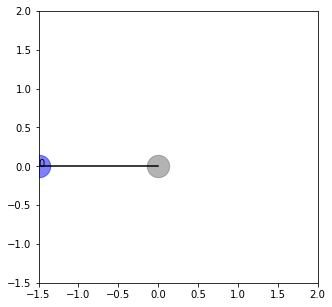

====0th kernel info====
0th-p_support:
torch.Size([1, 2])


0th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


0th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


0th-p_center:
torch.Size([2])


0th-edge_attr_support:
tensor([[1.]])


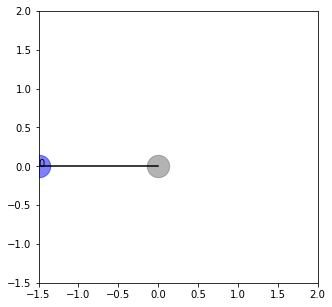

====1th kernel info====
1th-p_support:
torch.Size([1, 2])


1th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


1th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


1th-p_center:
torch.Size([2])


1th-edge_attr_support:
tensor([[1.]])


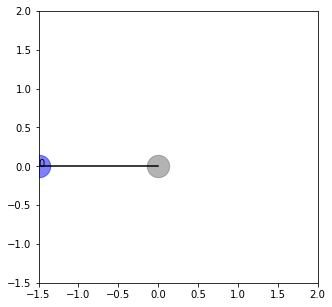

====2th kernel info====
2th-p_support:
torch.Size([1, 2])


2th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


2th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


2th-p_center:
torch.Size([2])


2th-edge_attr_support:
tensor([[1.]])


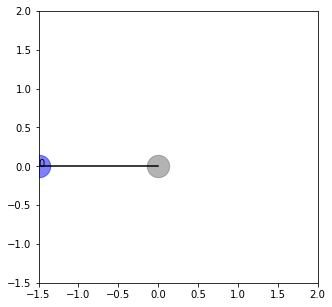

====3th kernel info====
3th-p_support:
torch.Size([1, 2])


3th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


3th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


3th-p_center:
torch.Size([2])


3th-edge_attr_support:
tensor([[1.]])


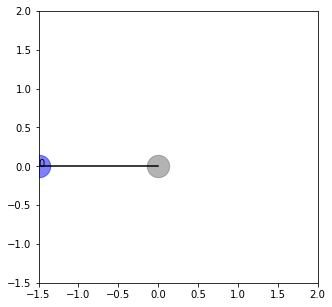

====4th kernel info====
4th-p_support:
torch.Size([1, 2])


4th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


4th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


4th-p_center:
torch.Size([2])


4th-edge_attr_support:
tensor([[1.]])


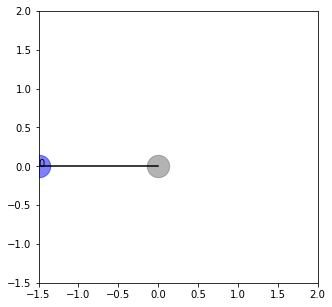

====5th kernel info====
5th-p_support:
torch.Size([1, 2])


5th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


5th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


5th-p_center:
torch.Size([2])


5th-edge_attr_support:
tensor([[1.]])


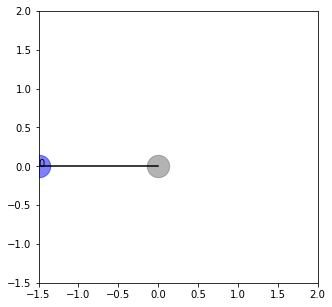

====6th kernel info====
6th-p_support:
torch.Size([1, 2])


6th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


6th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


6th-p_center:
torch.Size([2])


6th-edge_attr_support:
tensor([[1.]])


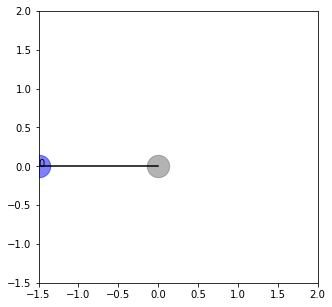

====7th kernel info====
7th-p_support:
torch.Size([1, 2])


7th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


7th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


7th-p_center:
torch.Size([2])


7th-edge_attr_support:
tensor([[1.]])


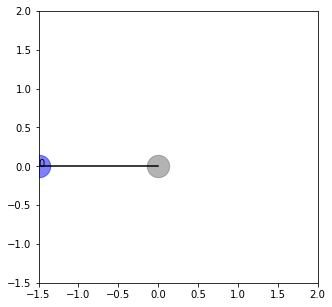

====8th kernel info====
8th-p_support:
torch.Size([1, 2])


8th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


8th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


8th-p_center:
torch.Size([2])


8th-edge_attr_support:
tensor([[1.]])


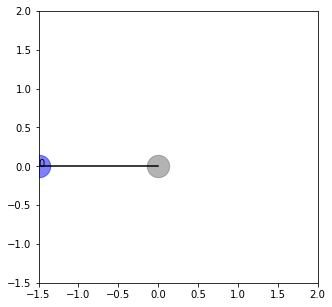

====9th kernel info====
9th-p_support:
torch.Size([1, 2])


9th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


9th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


9th-p_center:
torch.Size([2])


9th-edge_attr_support:
tensor([[1.]])


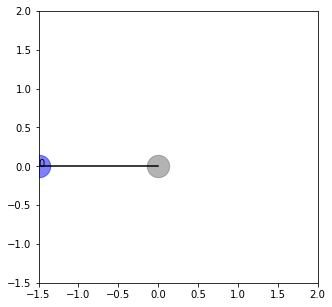

====10th kernel info====
10th-p_support:
torch.Size([1, 2])


10th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


10th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


10th-p_center:
torch.Size([2])


10th-edge_attr_support:
tensor([[1.]])


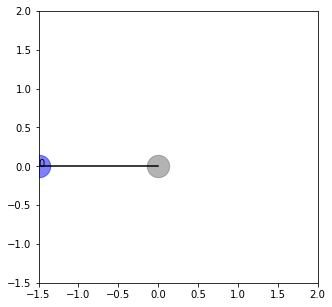

====11th kernel info====
11th-p_support:
torch.Size([1, 2])


11th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


11th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


11th-p_center:
torch.Size([2])


11th-edge_attr_support:
tensor([[1.]])


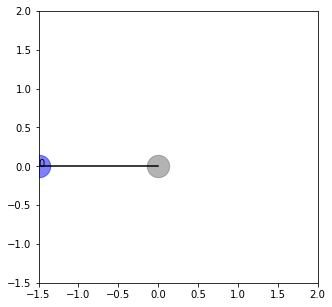

====12th kernel info====
12th-p_support:
torch.Size([1, 2])


12th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


12th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


12th-p_center:
torch.Size([2])


12th-edge_attr_support:
tensor([[1.]])


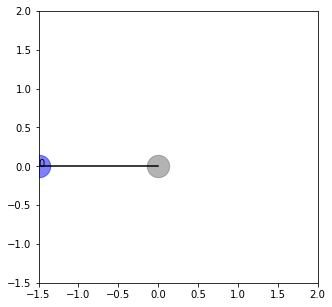

====13th kernel info====
13th-p_support:
torch.Size([1, 2])


13th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


13th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


13th-p_center:
torch.Size([2])


13th-edge_attr_support:
tensor([[1.]])


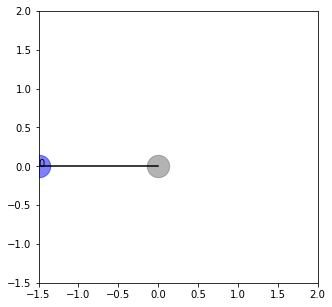

====14th kernel info====
14th-p_support:
torch.Size([1, 2])


14th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


14th-x_center:
tensor([[1.0000, 1.0080, 1.2000, 1.0000, 1.0000]])


14th-p_center:
torch.Size([2])


14th-edge_attr_support:
tensor([[1.]])


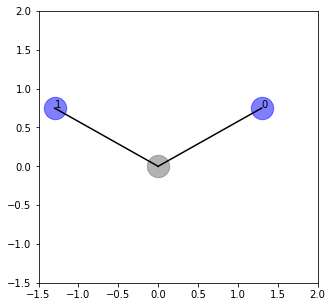

====0th kernel info====
0th-p_support:
torch.Size([2, 2])


0th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


0th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


0th-p_center:
torch.Size([2])


0th-edge_attr_support:
tensor([[1.],
        [1.]])


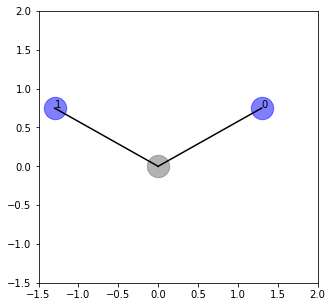

====1th kernel info====
1th-p_support:
torch.Size([2, 2])


1th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


1th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


1th-p_center:
torch.Size([2])


1th-edge_attr_support:
tensor([[1.],
        [1.]])


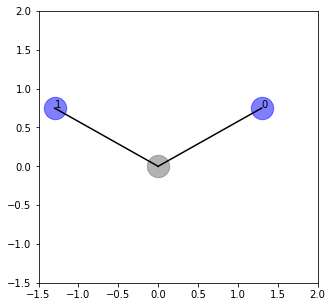

====2th kernel info====
2th-p_support:
torch.Size([2, 2])


2th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


2th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


2th-p_center:
torch.Size([2])


2th-edge_attr_support:
tensor([[1.],
        [1.]])


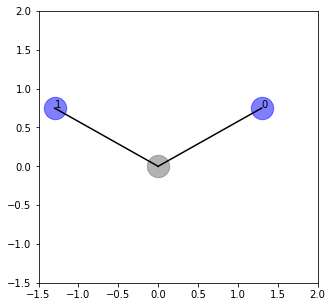

====3th kernel info====
3th-p_support:
torch.Size([2, 2])


3th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


3th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


3th-p_center:
torch.Size([2])


3th-edge_attr_support:
tensor([[1.],
        [1.]])


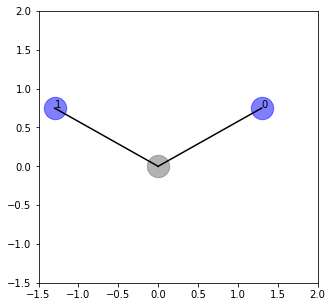

====4th kernel info====
4th-p_support:
torch.Size([2, 2])


4th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


4th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


4th-p_center:
torch.Size([2])


4th-edge_attr_support:
tensor([[1.],
        [1.]])


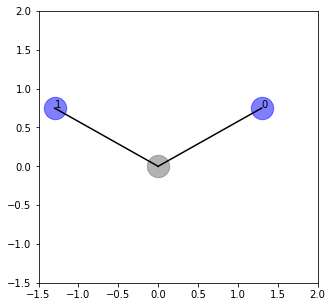

====5th kernel info====
5th-p_support:
torch.Size([2, 2])


5th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


5th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


5th-p_center:
torch.Size([2])


5th-edge_attr_support:
tensor([[1.],
        [1.]])


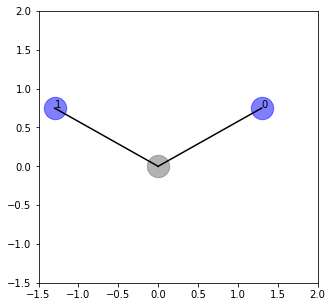

====6th kernel info====
6th-p_support:
torch.Size([2, 2])


6th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


6th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


6th-p_center:
torch.Size([2])


6th-edge_attr_support:
tensor([[1.],
        [1.]])


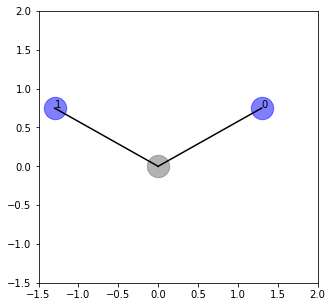

====7th kernel info====
7th-p_support:
torch.Size([2, 2])


7th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


7th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


7th-p_center:
torch.Size([2])


7th-edge_attr_support:
tensor([[1.],
        [1.]])


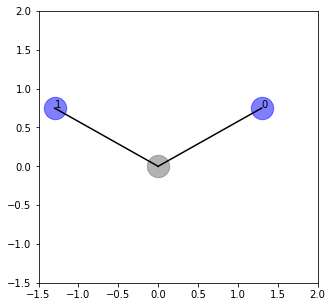

====8th kernel info====
8th-p_support:
torch.Size([2, 2])


8th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


8th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


8th-p_center:
torch.Size([2])


8th-edge_attr_support:
tensor([[1.],
        [1.]])


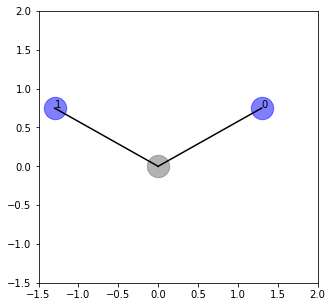

====9th kernel info====
9th-p_support:
torch.Size([2, 2])


9th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


9th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


9th-p_center:
torch.Size([2])


9th-edge_attr_support:
tensor([[1.],
        [1.]])


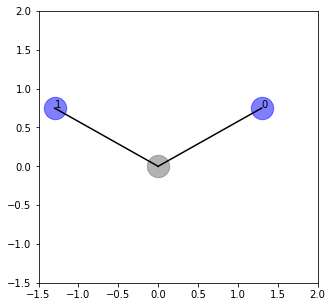

====10th kernel info====
10th-p_support:
torch.Size([2, 2])


10th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


10th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


10th-p_center:
torch.Size([2])


10th-edge_attr_support:
tensor([[1.],
        [1.]])


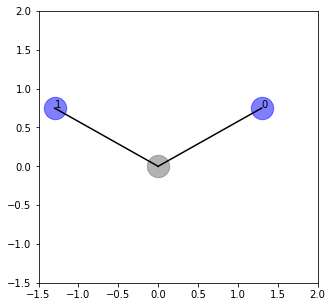

====11th kernel info====
11th-p_support:
torch.Size([2, 2])


11th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


11th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


11th-p_center:
torch.Size([2])


11th-edge_attr_support:
tensor([[1.],
        [1.]])


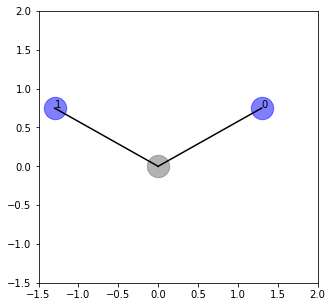

====12th kernel info====
12th-p_support:
torch.Size([2, 2])


12th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


12th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


12th-p_center:
torch.Size([2])


12th-edge_attr_support:
tensor([[1.],
        [1.]])


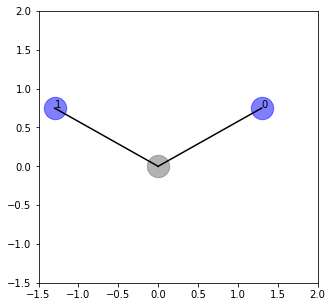

====13th kernel info====
13th-p_support:
torch.Size([2, 2])


13th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


13th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


13th-p_center:
torch.Size([2])


13th-edge_attr_support:
tensor([[1.],
        [1.]])


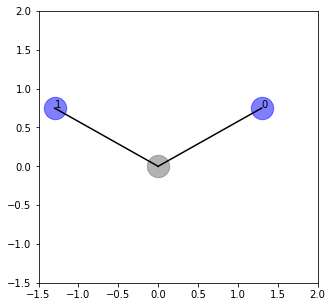

====14th kernel info====
14th-p_support:
torch.Size([2, 2])


14th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


14th-x_center:
tensor([[ 8.0000, 15.9990,  1.5500,  2.0000,  6.0000]])


14th-p_center:
torch.Size([2])


14th-edge_attr_support:
tensor([[1.],
        [1.]])


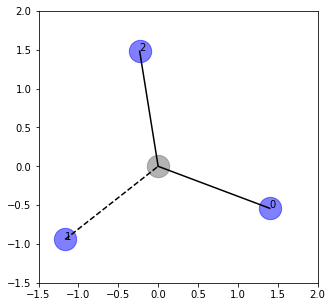

====0th kernel info====
0th-p_support:
torch.Size([3, 2])


0th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


0th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


0th-p_center:
torch.Size([2])


0th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


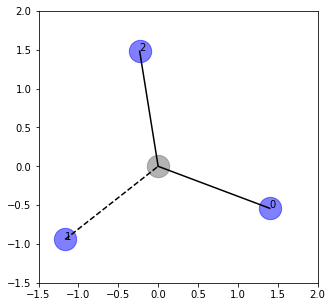

====1th kernel info====
1th-p_support:
torch.Size([3, 2])


1th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


1th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


1th-p_center:
torch.Size([2])


1th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


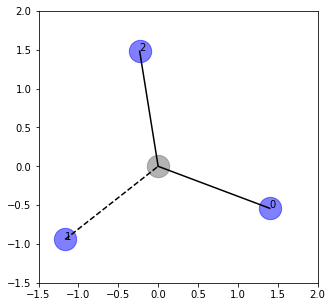

====2th kernel info====
2th-p_support:
torch.Size([3, 2])


2th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


2th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


2th-p_center:
torch.Size([2])


2th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


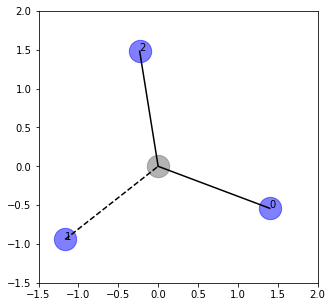

====3th kernel info====
3th-p_support:
torch.Size([3, 2])


3th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


3th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


3th-p_center:
torch.Size([2])


3th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


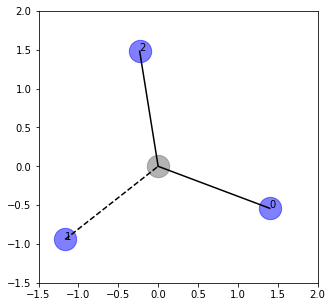

====4th kernel info====
4th-p_support:
torch.Size([3, 2])


4th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


4th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


4th-p_center:
torch.Size([2])


4th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


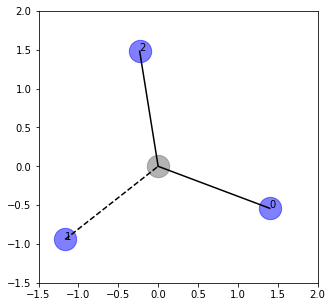

====5th kernel info====
5th-p_support:
torch.Size([3, 2])


5th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


5th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


5th-p_center:
torch.Size([2])


5th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


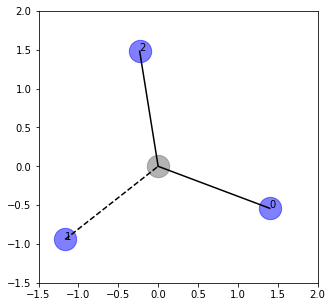

====6th kernel info====
6th-p_support:
torch.Size([3, 2])


6th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


6th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


6th-p_center:
torch.Size([2])


6th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


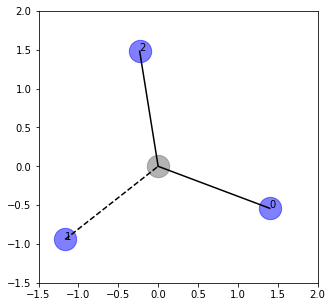

====7th kernel info====
7th-p_support:
torch.Size([3, 2])


7th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


7th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


7th-p_center:
torch.Size([2])


7th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


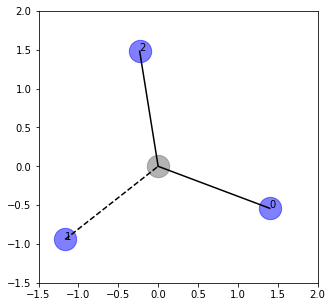

====8th kernel info====
8th-p_support:
torch.Size([3, 2])


8th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


8th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


8th-p_center:
torch.Size([2])


8th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


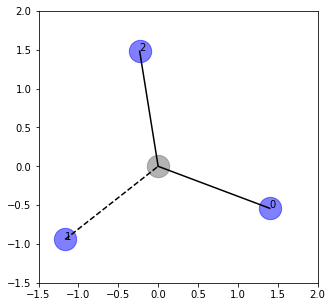

====9th kernel info====
9th-p_support:
torch.Size([3, 2])


9th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


9th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


9th-p_center:
torch.Size([2])


9th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


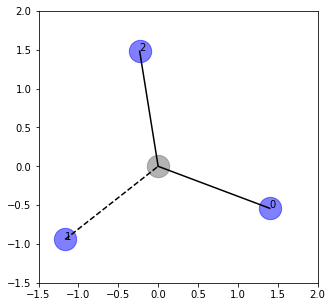

====10th kernel info====
10th-p_support:
torch.Size([3, 2])


10th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


10th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


10th-p_center:
torch.Size([2])


10th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


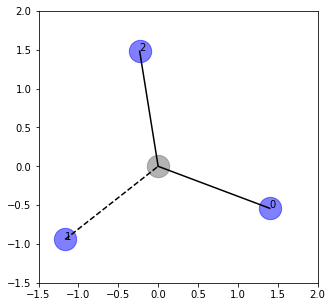

====11th kernel info====
11th-p_support:
torch.Size([3, 2])


11th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


11th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


11th-p_center:
torch.Size([2])


11th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


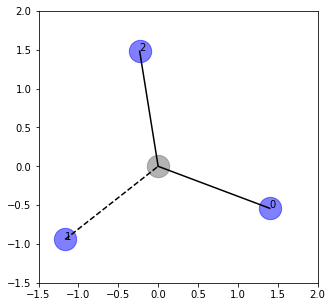

====12th kernel info====
12th-p_support:
torch.Size([3, 2])


12th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


12th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


12th-p_center:
torch.Size([2])


12th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


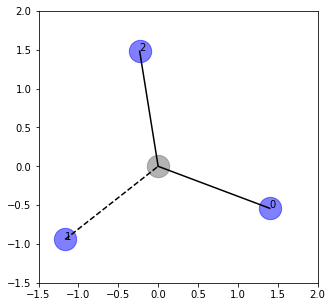

====13th kernel info====
13th-p_support:
torch.Size([3, 2])


13th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


13th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


13th-p_center:
torch.Size([2])


13th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


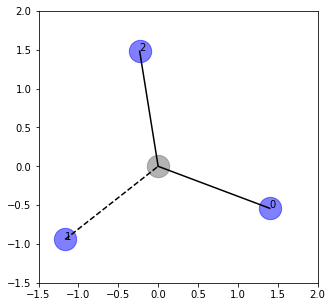

====14th kernel info====
14th-p_support:
torch.Size([3, 2])


14th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


14th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


14th-p_center:
torch.Size([2])


14th-edge_attr_support:
tensor([[1.],
        [2.],
        [1.]])


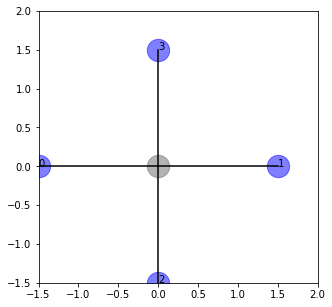

====0th kernel info====
0th-p_support:
torch.Size([4, 2])


0th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


0th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


0th-p_center:
torch.Size([2])


0th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


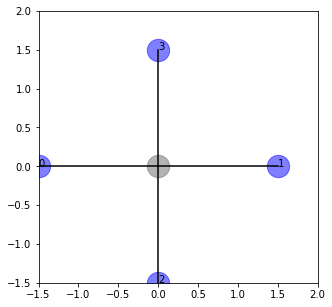

====1th kernel info====
1th-p_support:
torch.Size([4, 2])


1th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


1th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


1th-p_center:
torch.Size([2])


1th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


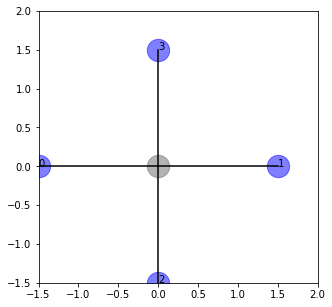

====2th kernel info====
2th-p_support:
torch.Size([4, 2])


2th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


2th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


2th-p_center:
torch.Size([2])


2th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


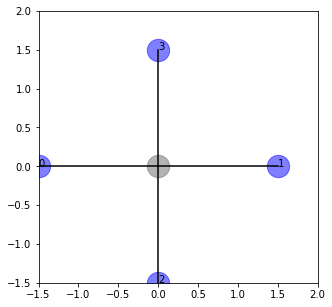

====3th kernel info====
3th-p_support:
torch.Size([4, 2])


3th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


3th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


3th-p_center:
torch.Size([2])


3th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


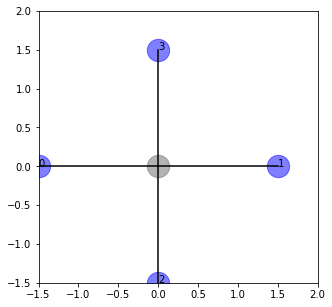

====4th kernel info====
4th-p_support:
torch.Size([4, 2])


4th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


4th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


4th-p_center:
torch.Size([2])


4th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


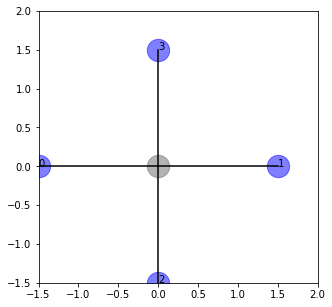

====5th kernel info====
5th-p_support:
torch.Size([4, 2])


5th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


5th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


5th-p_center:
torch.Size([2])


5th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


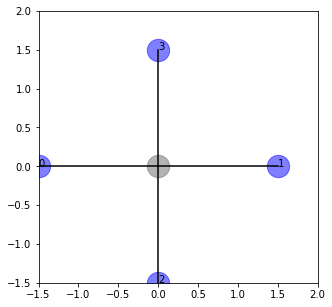

====6th kernel info====
6th-p_support:
torch.Size([4, 2])


6th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


6th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


6th-p_center:
torch.Size([2])


6th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


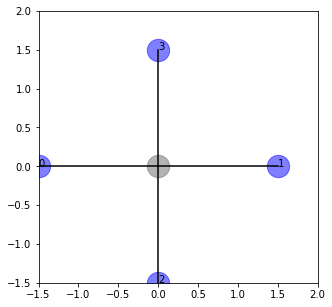

====7th kernel info====
7th-p_support:
torch.Size([4, 2])


7th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


7th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


7th-p_center:
torch.Size([2])


7th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


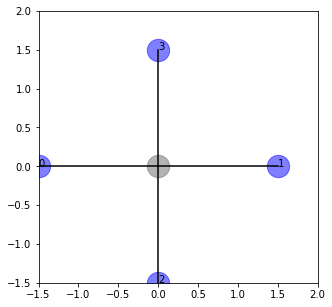

====8th kernel info====
8th-p_support:
torch.Size([4, 2])


8th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


8th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


8th-p_center:
torch.Size([2])


8th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


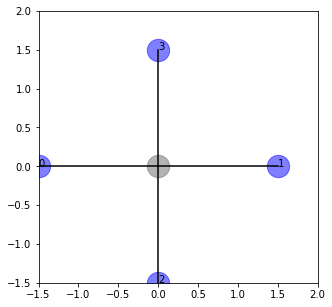

====9th kernel info====
9th-p_support:
torch.Size([4, 2])


9th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


9th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


9th-p_center:
torch.Size([2])


9th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


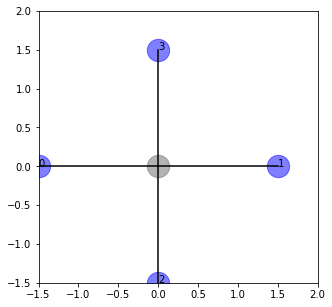

====10th kernel info====
10th-p_support:
torch.Size([4, 2])


10th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


10th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


10th-p_center:
torch.Size([2])


10th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


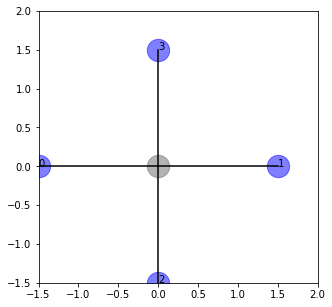

====11th kernel info====
11th-p_support:
torch.Size([4, 2])


11th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


11th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


11th-p_center:
torch.Size([2])


11th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


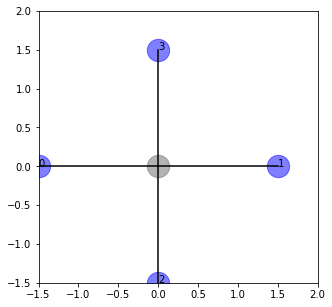

====12th kernel info====
12th-p_support:
torch.Size([4, 2])


12th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


12th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


12th-p_center:
torch.Size([2])


12th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


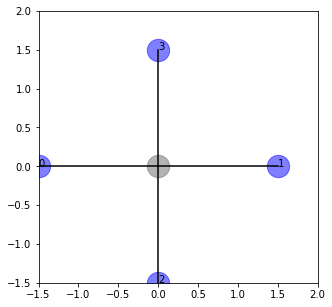

====13th kernel info====
13th-p_support:
torch.Size([4, 2])


13th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


13th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


13th-p_center:
torch.Size([2])


13th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


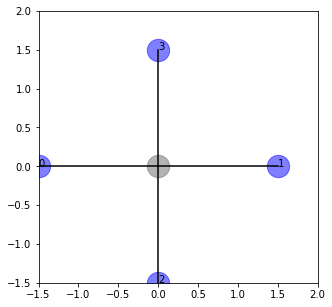

====14th kernel info====
14th-p_support:
torch.Size([4, 2])


14th-x_support:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000],
        [ 1.0000,  1.0080,  1.2000,  1.0000,  1.0000]])


14th-x_center:
tensor([[ 6.0000, 12.0110,  1.7000,  4.0000,  4.0000]])


14th-p_center:
torch.Size([2])


14th-edge_attr_support:
tensor([[1.],
        [1.],
        [1.],
        [1.]])


In [13]:
# visualize saved model kernels
model = Predefined1HopKernelSetConv(D=2, node_attr_dim=5, edge_attr_dim=1, L1=15, L2=15, L3=15, L4=15)
model.load_state_dict(torch.load('../saved_kernellayers/0th_layer.pth'))

print(list(model.state_dict()))
vis_kernel_in_kernelsetconv(model)